## 1) Coding environment setup 

In [1]:
## TODO: Import libraries 
from IPython.display import Image

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import time
import sweetviz as sv
import xgboost as xgb
import math
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

## 2) Data Cleaning and Exploratory Data Analysis

The file *outcome.csv* contains the results of EPA investigations of air pollution violations by firm. Each row includes a unique firm identifier, the year the firm was inspected, and a binary outcome from the inspection. A separate file, *unclean.csv*, contains additional firm-level variables which are constant across years. There are some issues with the data in both of these files which will need to be addressed in the course of the following analyses. 

#### 1. Resolve the following issues to process the data:  
- Join the firm characteristics (*unclean.csv*) to the panel of inspection outcomes (*outcome.csv*). IMPORTANT: Do NOT edit or address any missing values or perceived errors in the binary outcome variable provided in *outcome.csv*.
- Identify and remove duplicate observations. 
- Clean string data for the state variable (i.e., standardize capitalization and remove leading and trailing white space). Hint: you should end up with seven categories. 
- Identify and handle implausible data values. Please briefly describe the logic behind the decisions that you make. If you decide to address potential outliers, make sure you explain your criteria for identifying them. 

Save the cleaned and merged dataset in the *output/* directory with the name *cleaned.csv*.

In [5]:
# Import unclean dataset
unclean = pd.read_csv('unclean.csv')
unclean

,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population
0,110070089714,2021,KY,0,0,92065,90.063083,1.549643,1.327482,3.817883,0.501920,11.497532,50636.0,36460
1,110009954148,2021,FL,5,2,41183,95.118975,4.392923,0.488103,0.000000,0.000000,0.000000,36176.0,1639
2,110070089965,2021,KY,0,0,92536,88.215233,2.993558,2.084123,1.515726,5.001895,8.450171,38272.0,2639
3,110070097696,2021,MO,0,0,95602,96.417043,0.710136,1.425651,3.292447,0.462664,1.775339,50973.0,18588
4,110070094258,2021,MO,0,0,95330,52.029382,7.399568,5.395086,29.830677,1.249170,15.450697,44398.0,24096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,110065570670,2021,MO,0,0,95823,33.915539,25.266569,2.332946,25.134212,5.462507,19.972292,31239.0,80842
406,110070094258,2021,MO,0,0,95330,52.029382,7.399568,5.395086,29.830677,1.249170,15.450697,44398.0,24096
407,110070825482,2021,FL,0,0,42431,88.285001,11.941617,0.649126,1.325139,0.003841,0.964087,35783.0,26035
408,110070095876,2021,MO,0,0,95829,46.643000,10.019301,2.016268,42.696629,2.447095,7.103467,NaN,29014


In [6]:
# Import outcome dataset
outcome = pd.read_csv('outcome.csv')
outcome

,registry_id,year,violation
0,110070089714,2021,1.0
1,110009954148,2021,0.0
2,110070089965,2021,0.0
3,110070097696,2021,0.0
4,110070094258,2021,0.0
...,...,...,...
395,110070919624,2021,NaN
396,110070392205,2021,NaN
397,110070946293,2021,0.0
398,110070916913,2021,0.0


In [7]:
# Merge the two dataframes:
# Using both 'registry_id' and 'year' as indexes I will not have duplicate columns
merged_df = pd.merge(unclean, outcome, on=('registry_id', 'year'), how='inner')
merged_df

,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population,violation
0,110070089714,2021,KY,0,0,92065,90.063083,1.549643,1.327482,3.817883,0.501920,11.497532,50636.0,36460,1.0
1,110009954148,2021,FL,5,2,41183,95.118975,4.392923,0.488103,0.000000,0.000000,0.000000,36176.0,1639,0.0
2,110070089965,2021,KY,0,0,92536,88.215233,2.993558,2.084123,1.515726,5.001895,8.450171,38272.0,2639,0.0
3,110070097696,2021,MO,0,0,95602,96.417043,0.710136,1.425651,3.292447,0.462664,1.775339,50973.0,18588,0.0
4,110070094258,2021,MO,0,0,95330,52.029382,7.399568,5.395086,29.830677,1.249170,15.450697,44398.0,24096,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,110070919624,2021,FL,0,0,40759,100.000000,0.000000,0.000000,1.604730,0.000000,0.000000,25762.0,2368,NaN
406,110070392205,2021,ca,0,0,34614,97.548638,3.981842,0.531777,2.957198,0.129702,6.160830,NaN,7710,NaN
407,110070946293,2021,FL,0,0,40356,93.556917,5.202377,0.564985,1.674614,0.013560,1.353703,40113.0,44249,0.0
408,110070916913,2021,FL,0,0,40982,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31429.0,380,0.0


In [8]:
# Identify duplicate rows
duplicates = merged_df.duplicated()
merged_df[duplicates]

,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population,violation
5,110070094258,2021,MO,0,0,95330,52.029382,7.399568,5.395086,29.830677,1.249170,15.450697,44398.0,24096,0.0
44,110070095876,2021,MO,0,0,95829,46.643000,10.019301,2.016268,42.696629,2.447095,7.103467,NaN,29014,0.0
69,110065570670,2021,MO,0,0,95823,33.915539,25.266569,2.332946,25.134212,5.462507,19.972292,31239.0,80842,NaN
127,110027970319,2021,CA,0,0,33330,77.655487,10.048844,0.879192,9.273852,0.657766,6.818626,NaN,15355,1.0
199,110070088120,2021,KY,0,0,91350,75.545829,5.664189,1.108492,14.358602,1.261299,12.838310,56281.0,38611,0.0
202,110070094163,2021,ky,0,0,90803,83.390714,4.224435,1.851680,10.350175,1.476381,5.095996,67562.0,32241,0.0
254,110000516727,2021,CA,0,0,33605,42.206743,55.775982,1.292839,1.794372,0.172750,8.247423,26326.0,17945,1.0
259,110070204424,2021,FL,0,0,65647,92.288468,0.142806,2.463406,6.926098,0.357015,4.676901,36563.0,2801,0.0
316,110071065776,2021,AK,0,0,32097,88.510371,11.693401,1.698103,1.384607,0.041799,1.008412,43081.0,19139,0.0
347,110070825482,2021,FL,0,0,42431,88.285001,11.941617,0.649126,1.325139,0.003841,0.964087,35783.0,26035,0.0


In [9]:
# Drop duplicates
df = merged_df.drop_duplicates()
df

,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population,violation
0,110070089714,2021,KY,0,0,92065,90.063083,1.549643,1.327482,3.817883,0.501920,11.497532,50636.0,36460,1.0
1,110009954148,2021,FL,5,2,41183,95.118975,4.392923,0.488103,0.000000,0.000000,0.000000,36176.0,1639,0.0
2,110070089965,2021,KY,0,0,92536,88.215233,2.993558,2.084123,1.515726,5.001895,8.450171,38272.0,2639,0.0
3,110070097696,2021,MO,0,0,95602,96.417043,0.710136,1.425651,3.292447,0.462664,1.775339,50973.0,18588,0.0
4,110070094258,2021,MO,0,0,95330,52.029382,7.399568,5.395086,29.830677,1.249170,15.450697,44398.0,24096,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,110070919624,2021,FL,0,0,40759,100.000000,0.000000,0.000000,1.604730,0.000000,0.000000,25762.0,2368,NaN
406,110070392205,2021,ca,0,0,34614,97.548638,3.981842,0.531777,2.957198,0.129702,6.160830,NaN,7710,NaN
407,110070946293,2021,FL,0,0,40356,93.556917,5.202377,0.564985,1.674614,0.013560,1.353703,40113.0,44249,0.0
408,110070916913,2021,FL,0,0,40982,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31429.0,380,0.0


In [10]:
# Sweetviz table
my_report = sv.analyze(df)
my_report.show_html()

Done! Use 'show' commands to display/save.   |██| [100%]   00:00 -> (00:00 left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


6% of earnings_media data are missing. 5% of violation data are missing.

Most of the distributions are exponentials

In [11]:
# Check 'state' values to assess data cleaning
df['state'].value_counts()

FL            121
CA             97
MO             58
KY             39
California     19
ca              9
MT              8
Ca              7
WY              6
AK              6
FL              5
Ky              4
fl              4
MO              3
CA              3
ky              3
Mo              3
Fl              3
KY              1
MT              1
Name: state, dtype: int64

In [12]:
# Delete trainling and leading white space and uppercase all the values
df['state1'] = df['state'].str.strip().str.upper()

# Check unique calues
df['state1'].value_counts()

FL            133
CA            116
MO             64
KY             47
CALIFORNIA     19
MT              9
AK              6
WY              6
Name: state1, dtype: int64

In [13]:
# Replace the last unlceaned value
df['state1'].replace('CALIFORNIA', 'CA', inplace=True)

# Drop former 'state' column
df = df.drop('state', axis=1)

In [14]:
# Have 'state1' back at the third place
cols = df.columns.tolist() 
cols.insert(2, cols.pop())  
df = df[cols]  
df.head()

,registry_id,year,state1,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population,violation
0,110070089714,2021,KY,0,0,92065,90.063083,1.549643,1.327482,3.817883,0.501920,11.497532,50636.0,36460,1.0
1,110009954148,2021,FL,5,2,41183,95.118975,4.392923,0.488103,0.000000,0.000000,0.000000,36176.0,1639,0.0
2,110070089965,2021,KY,0,0,92536,88.215233,2.993558,2.084123,1.515726,5.001895,8.450171,38272.0,2639,0.0
3,110070097696,2021,MO,0,0,95602,96.417043,0.710136,1.425651,3.292447,0.462664,1.775339,50973.0,18588,0.0
4,110070094258,2021,MO,0,0,95330,52.029382,7.399568,5.395086,29.830677,1.249170,15.450697,44398.0,24096,0.0


In [15]:
# Rename 'state1' to 'state'
df = df.rename(columns={'state1': 'state'})

# Check if I have seven categories
df['state'].value_counts()

CA    135
FL    133
MO     64
KY     47
MT      9
AK      6
WY      6
Name: state, dtype: int64

In [16]:
# Create separate dataframes for each state
outlier_df = df.drop(['registry_id', 'year', 'state', 'region_code', 'violation'], axis=1)

CA = df[df['state'] == 'CA'].drop(['registry_id', 'year', 'state', 'region_code', 
                                   'violation'], axis=1)

FL = df[df['state'] == 'FL'].drop(['registry_id', 'year', 'state', 'region_code', 
                                   'violation'], axis=1)

MO = df[df['state'] == 'MO'].drop(['registry_id', 'year', 'state', 'region_code', 
                                   'violation'], axis=1)

KY = df[df['state'] == 'KY'].drop(['registry_id', 'year', 'state', 'region_code', 
                                   'violation'], axis=1)

MT = df[df['state'] == 'MT'].drop(['registry_id', 'year', 'state', 'region_code', 
                                   'violation'], axis=1)

AK = df[df['state'] == 'AK'].drop(['registry_id', 'year', 'state', 'region_code', 
                                   'violation'], axis=1)

WY = df[df['state'] == 'WY'].drop(['registry_id', 'year', 'state', 'region_code', 
                                   'violation'], axis=1)

In [17]:
# Set parameters to display boxplots
num_columns = len(outlier_df.columns)
columns_per_row = num_columns // 2 + (num_columns % 2)  

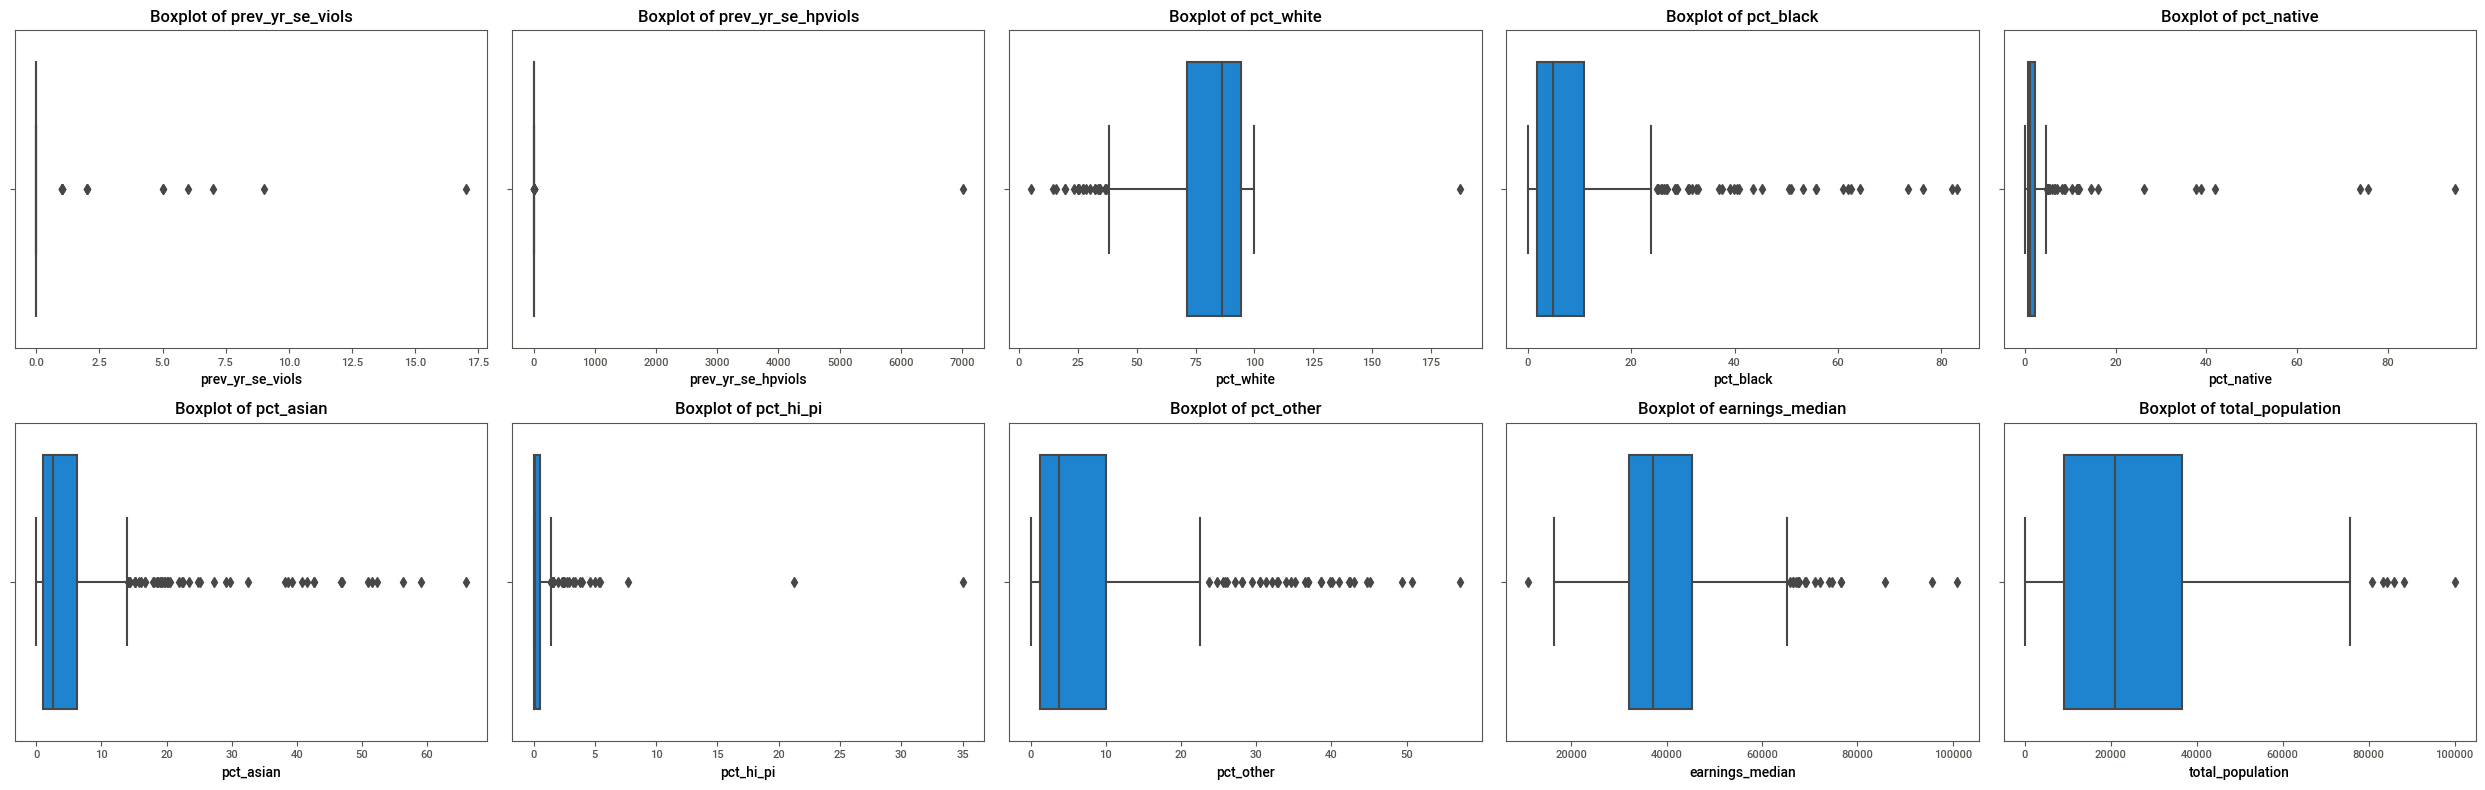

In [18]:
# Total boxplot
fig, axs = plt.subplots(2, columns_per_row, figsize=(5 * columns_per_row, 8)) 
for i, column in enumerate(outlier_df.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(x=outlier_df[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

if num_columns % 2 != 0:
    axs[1, -1].set_visible(False)

plt.tight_layout()
plt.show()

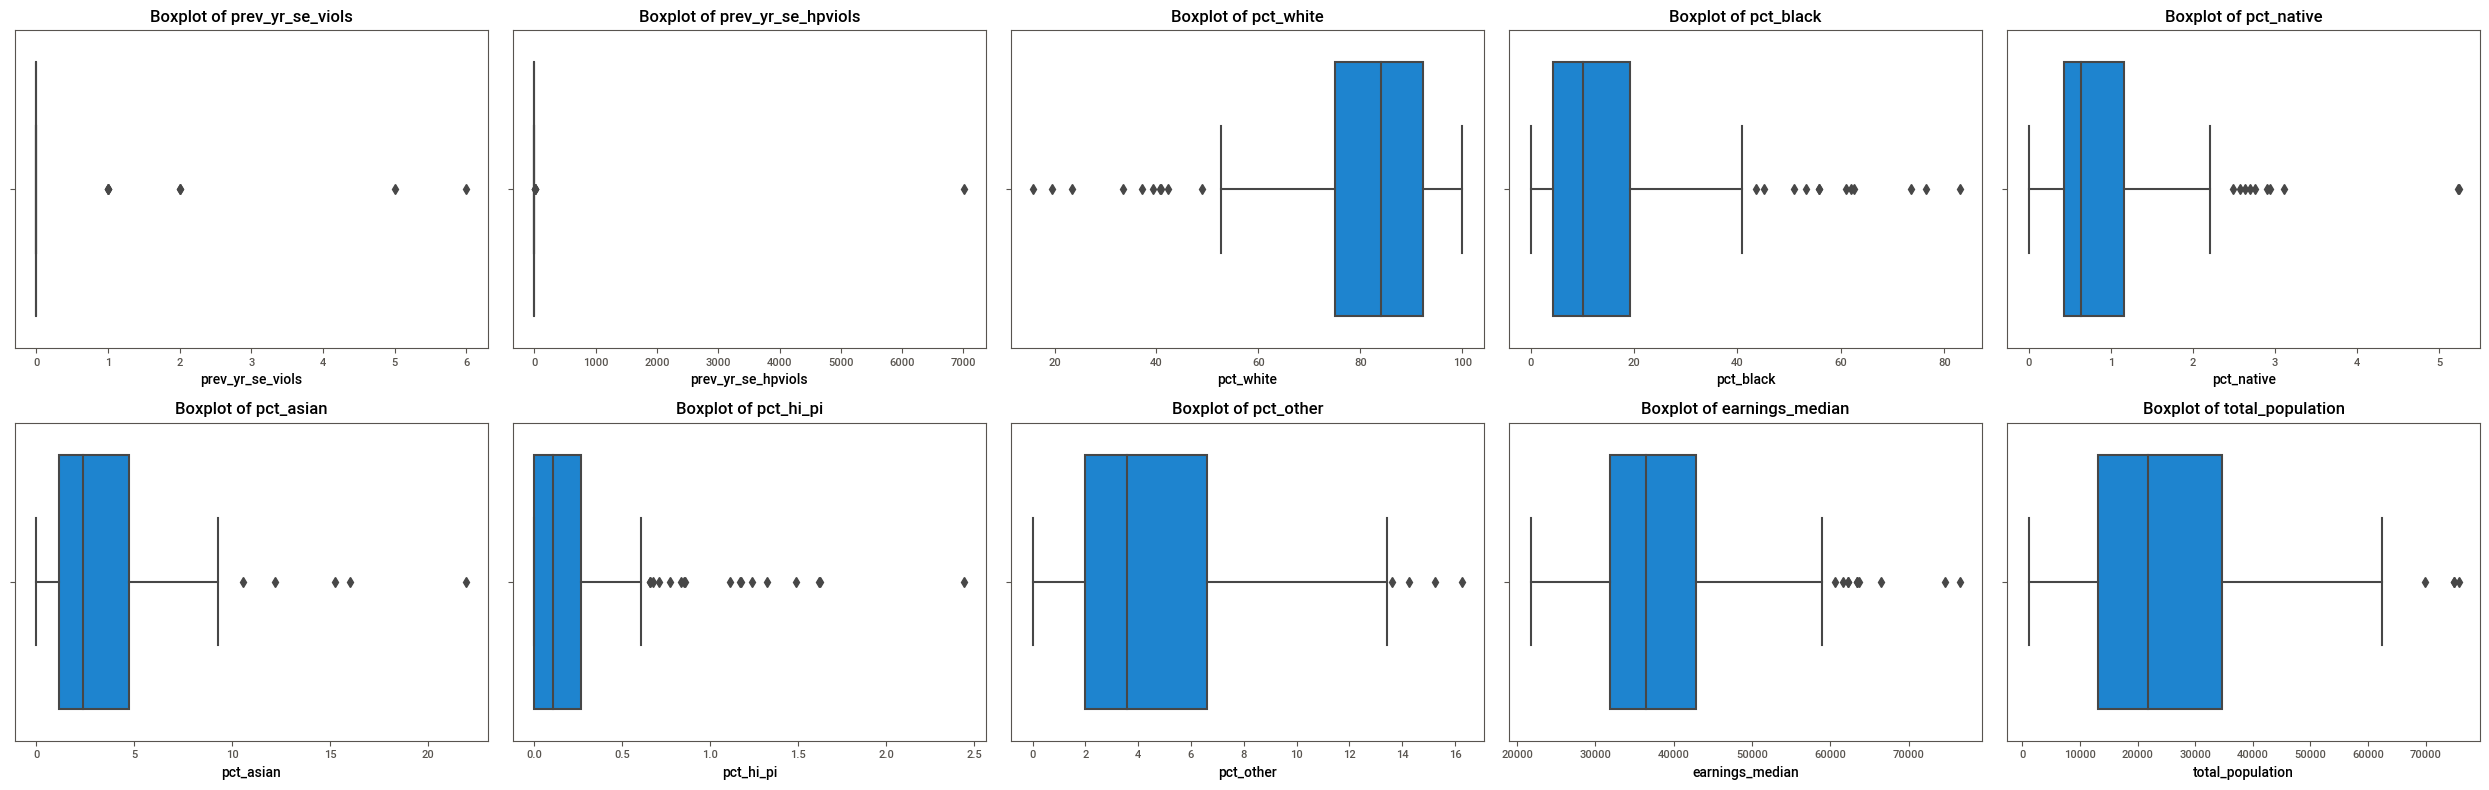

In [19]:
# CA
fig, axs = plt.subplots(2, columns_per_row, figsize=(5 * columns_per_row, 8)) 
for i, column in enumerate(CA.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(x=CA[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

if num_columns % 2 != 0:
    axs[1, -1].set_visible(False)

plt.tight_layout()
plt.show()

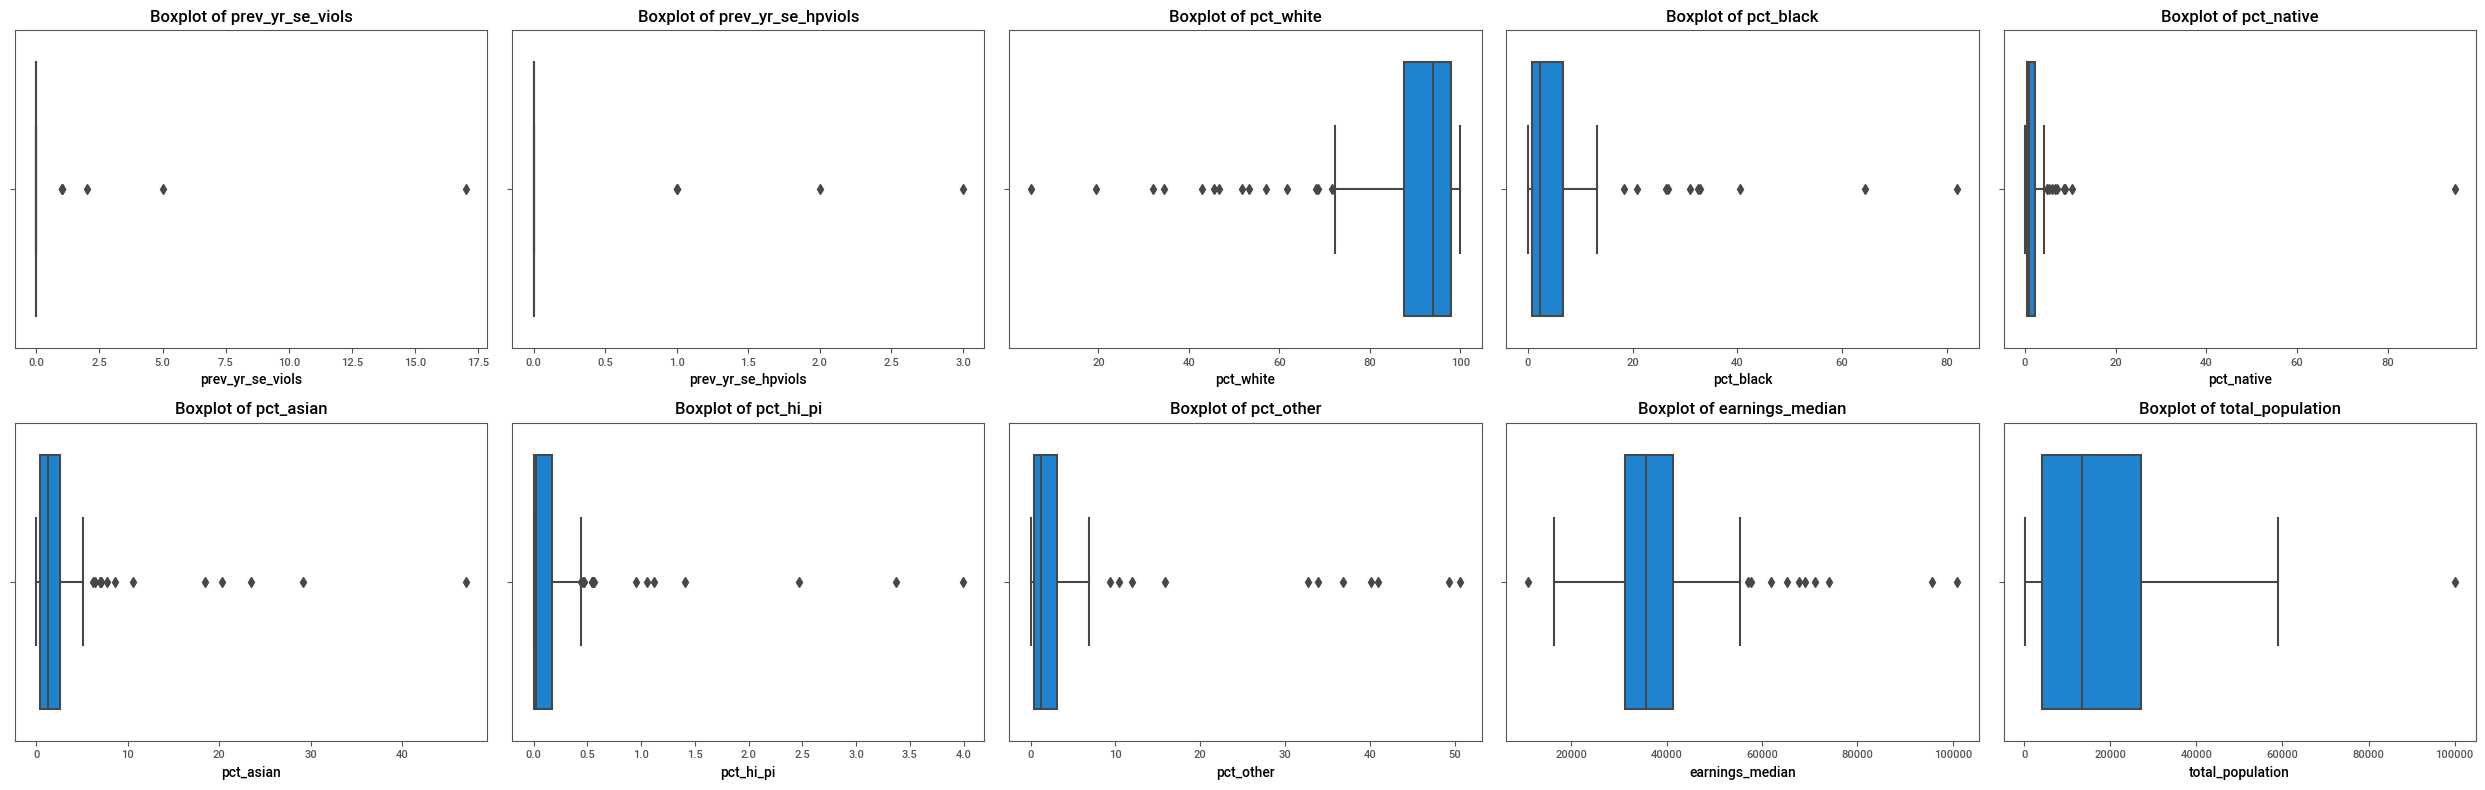

In [20]:
# FL
fig, axs = plt.subplots(2, columns_per_row, figsize=(5 * columns_per_row, 8)) 
for i, column in enumerate(CA.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(x=FL[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

if num_columns % 2 != 0:
    axs[1, -1].set_visible(False)

plt.tight_layout()
plt.show()

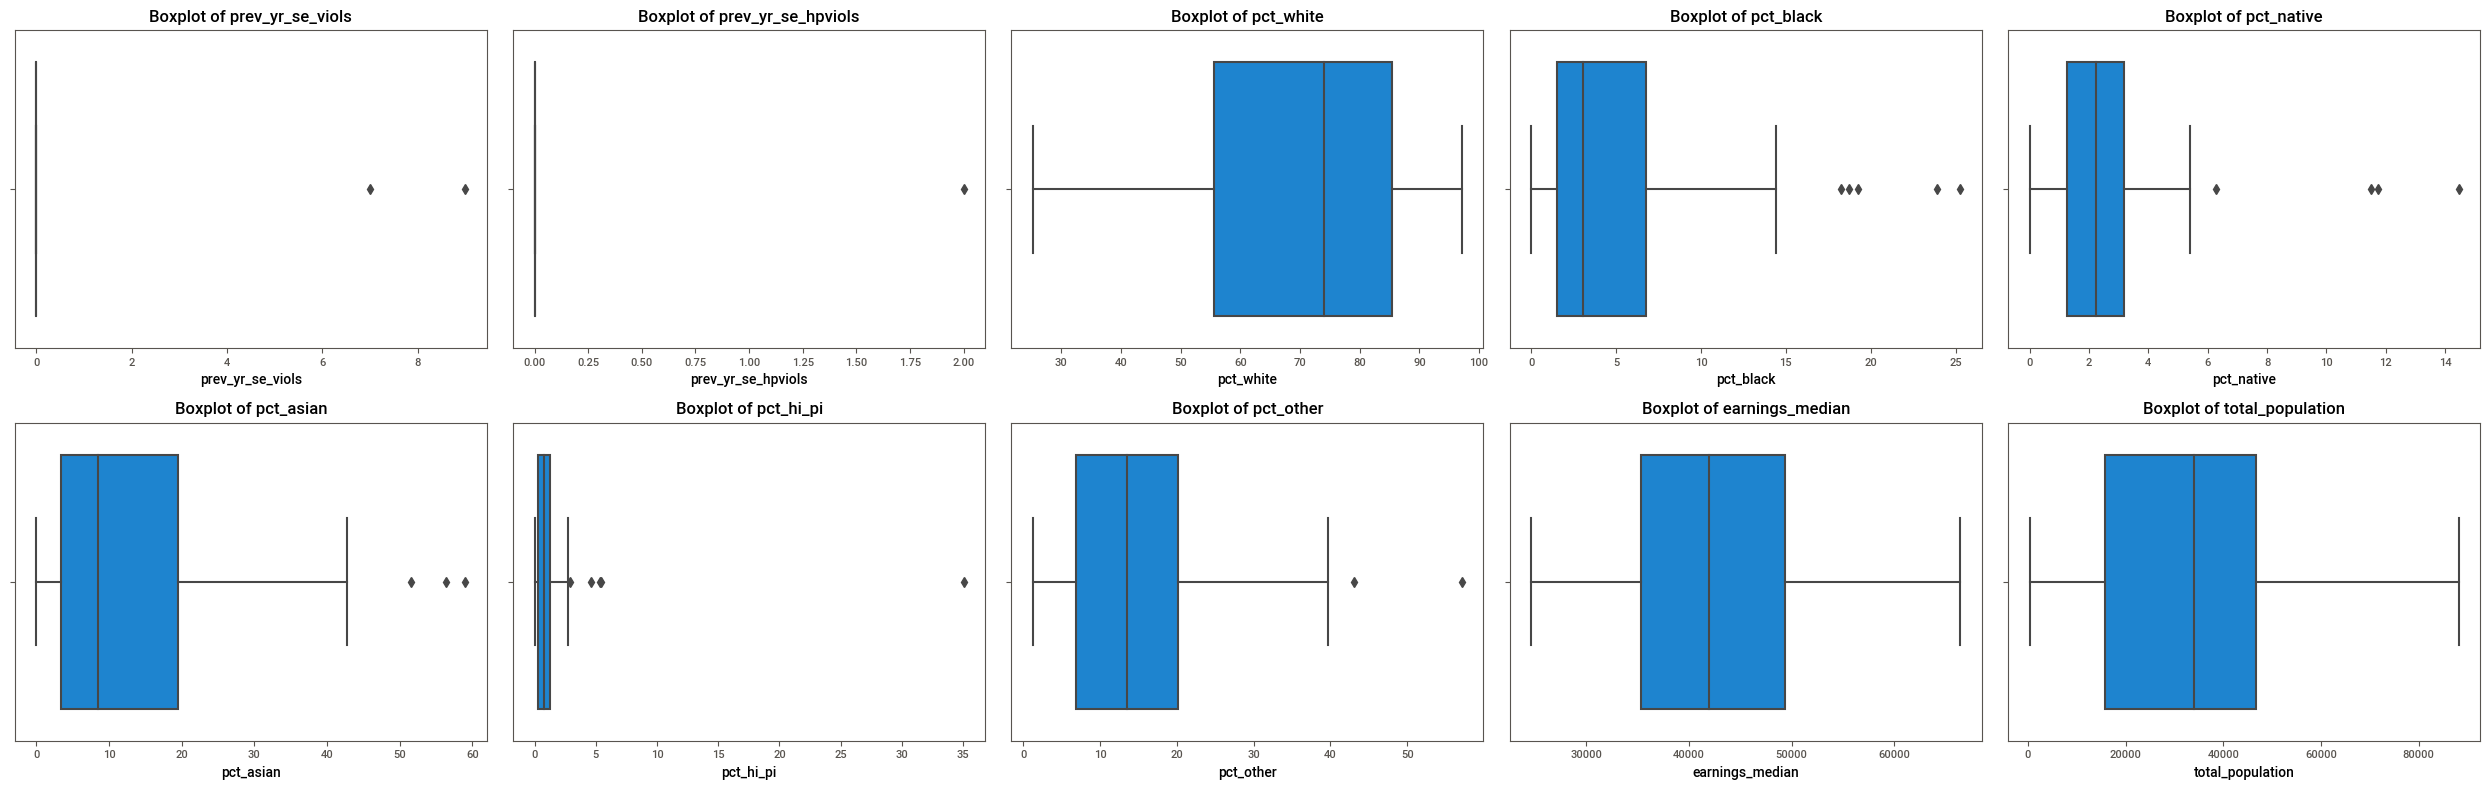

In [21]:
# MO
fig, axs = plt.subplots(2, columns_per_row, figsize=(5 * columns_per_row, 8)) 
for i, column in enumerate(MO.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(x=MO[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

if num_columns % 2 != 0:
    axs[1, -1].set_visible(False)

plt.tight_layout()
plt.show()

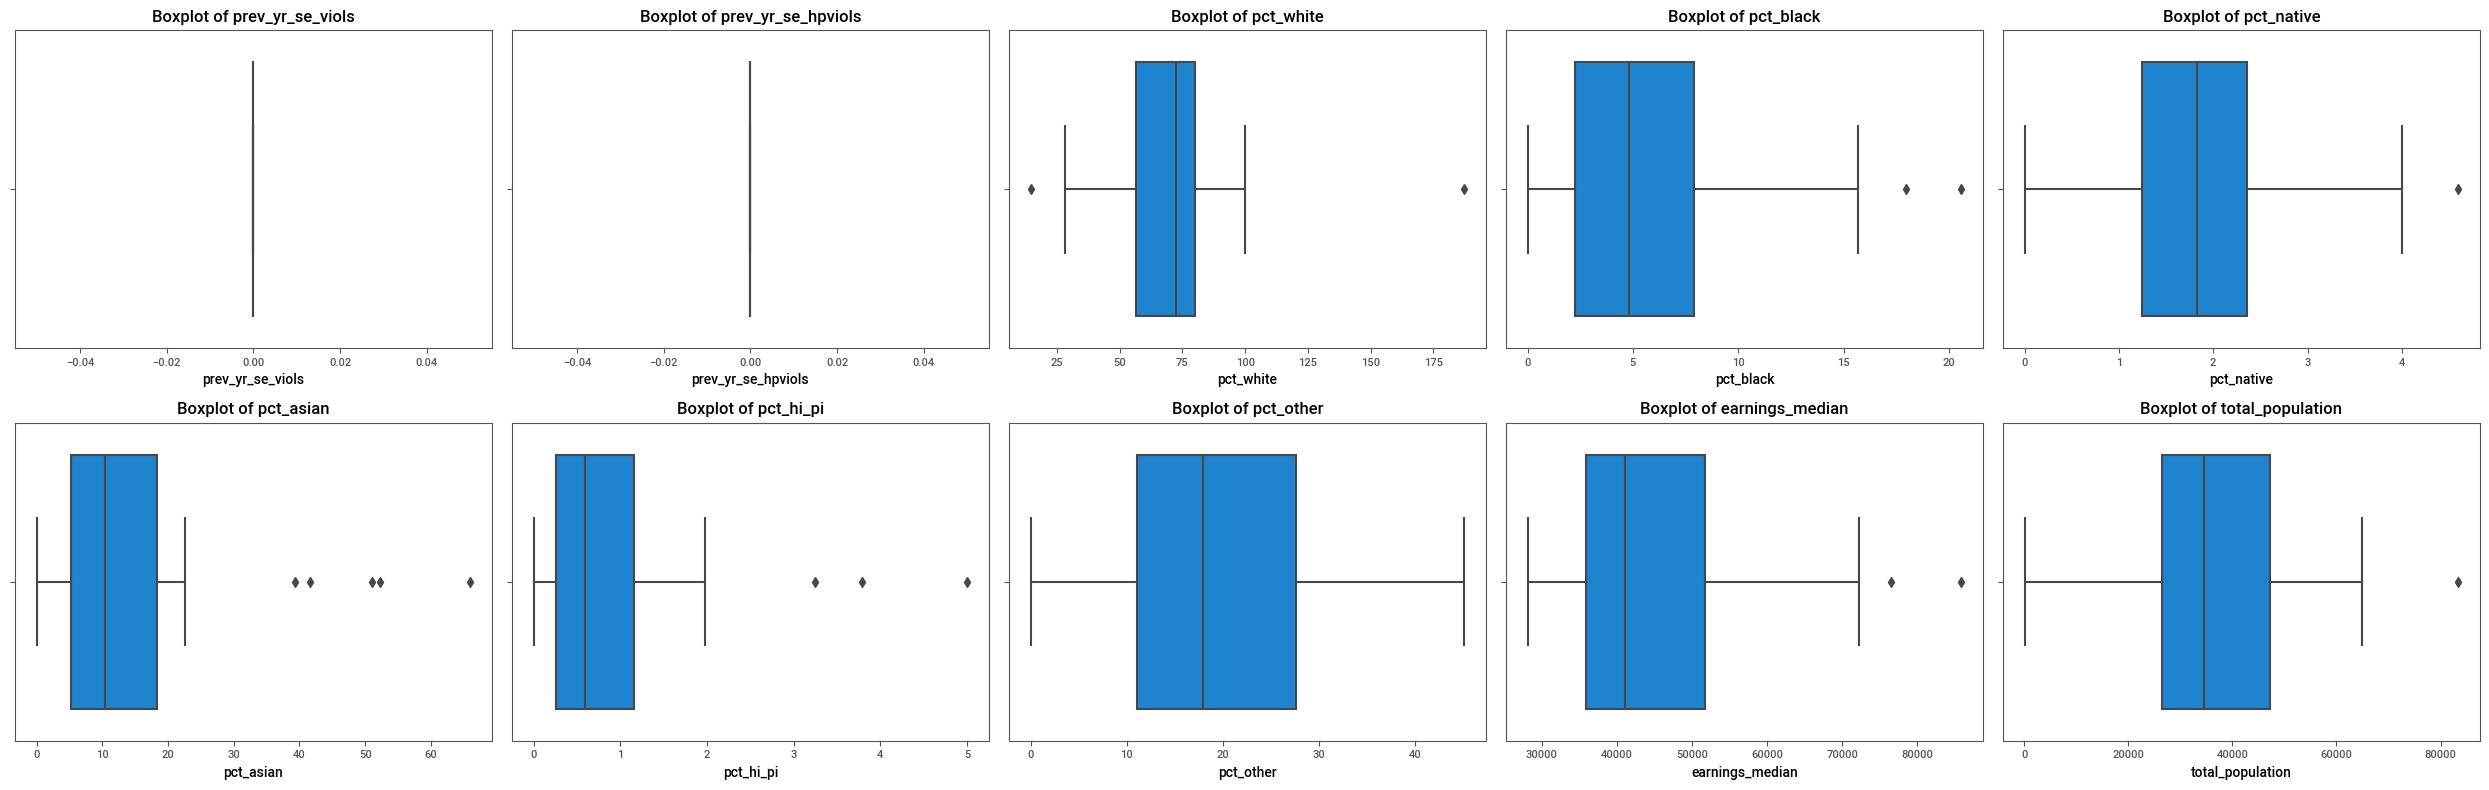

In [22]:
# KY
fig, axs = plt.subplots(2, columns_per_row, figsize=(5 * columns_per_row, 8)) 
for i, column in enumerate(KY.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(x=KY[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

if num_columns % 2 != 0:
    axs[1, -1].set_visible(False)

plt.tight_layout()
plt.show()

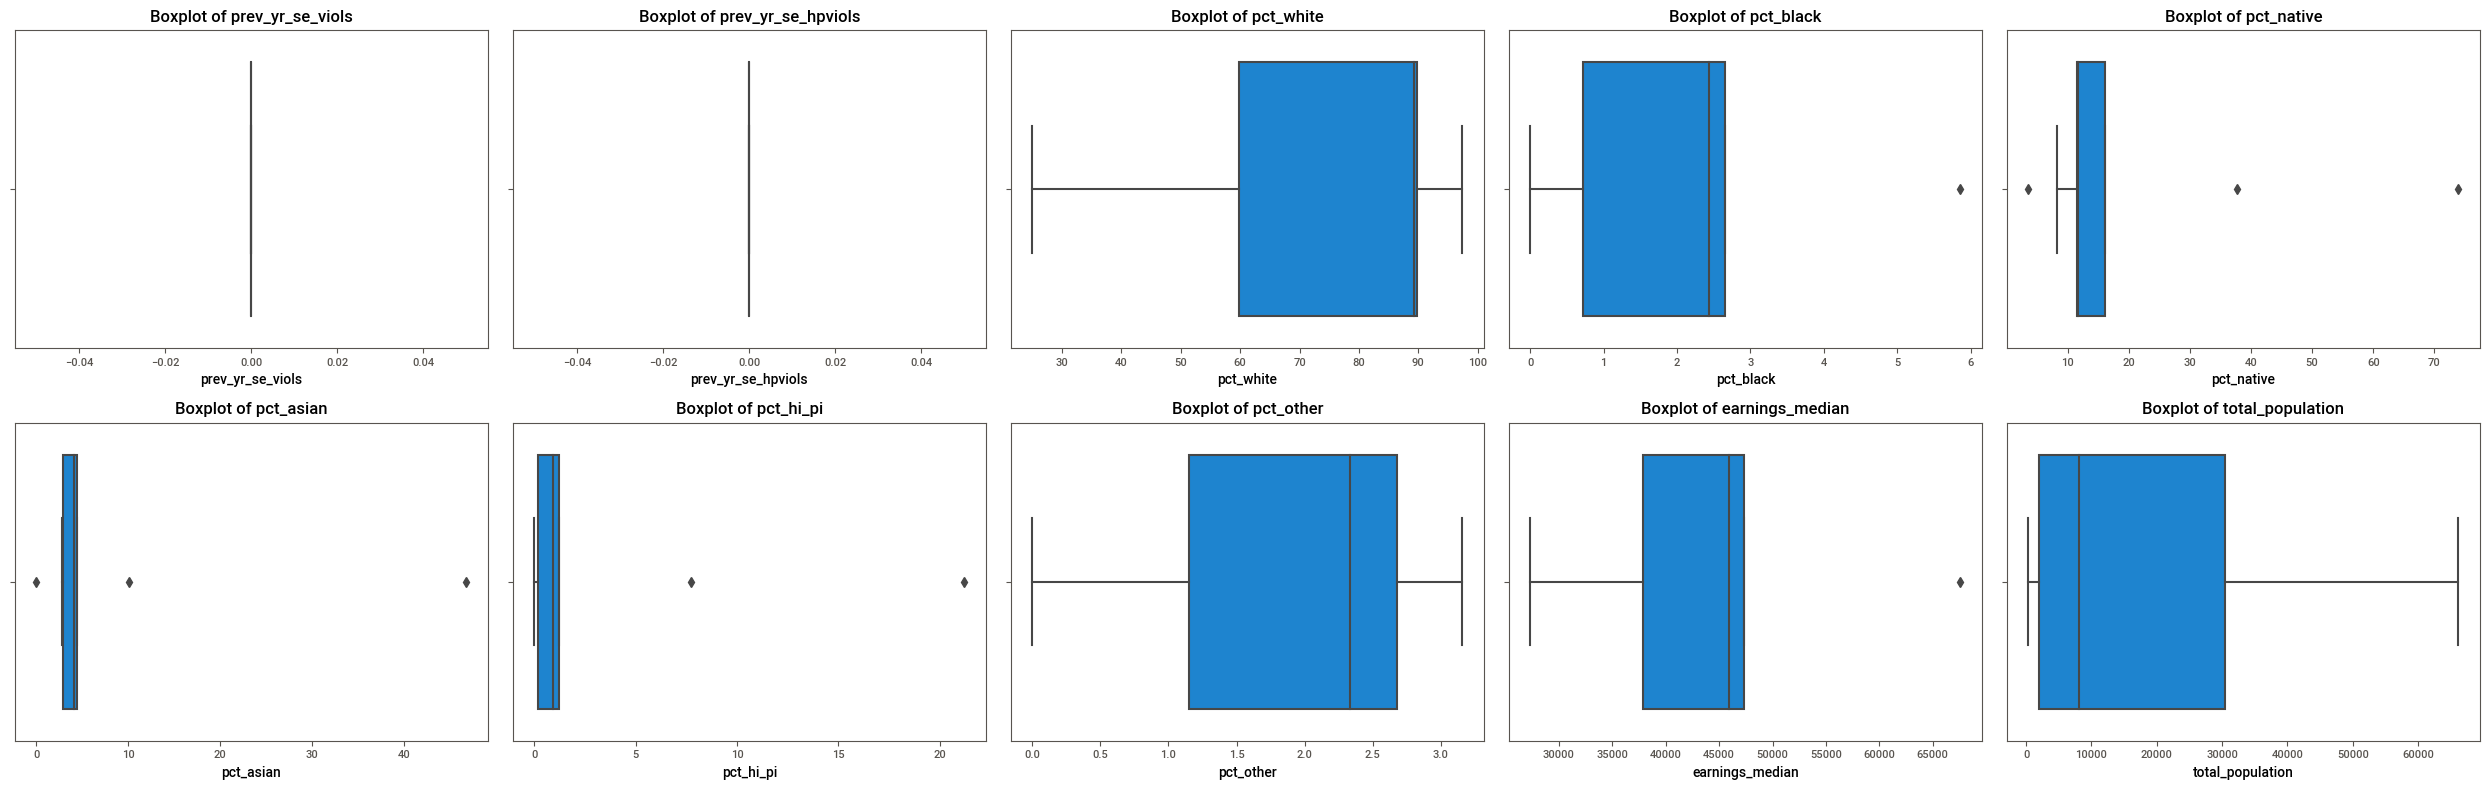

In [23]:
# MT
fig, axs = plt.subplots(2, columns_per_row, figsize=(5 * columns_per_row, 8)) 
for i, column in enumerate(MT.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(x=MT[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

if num_columns % 2 != 0:
    axs[1, -1].set_visible(False)

plt.tight_layout()
plt.show()

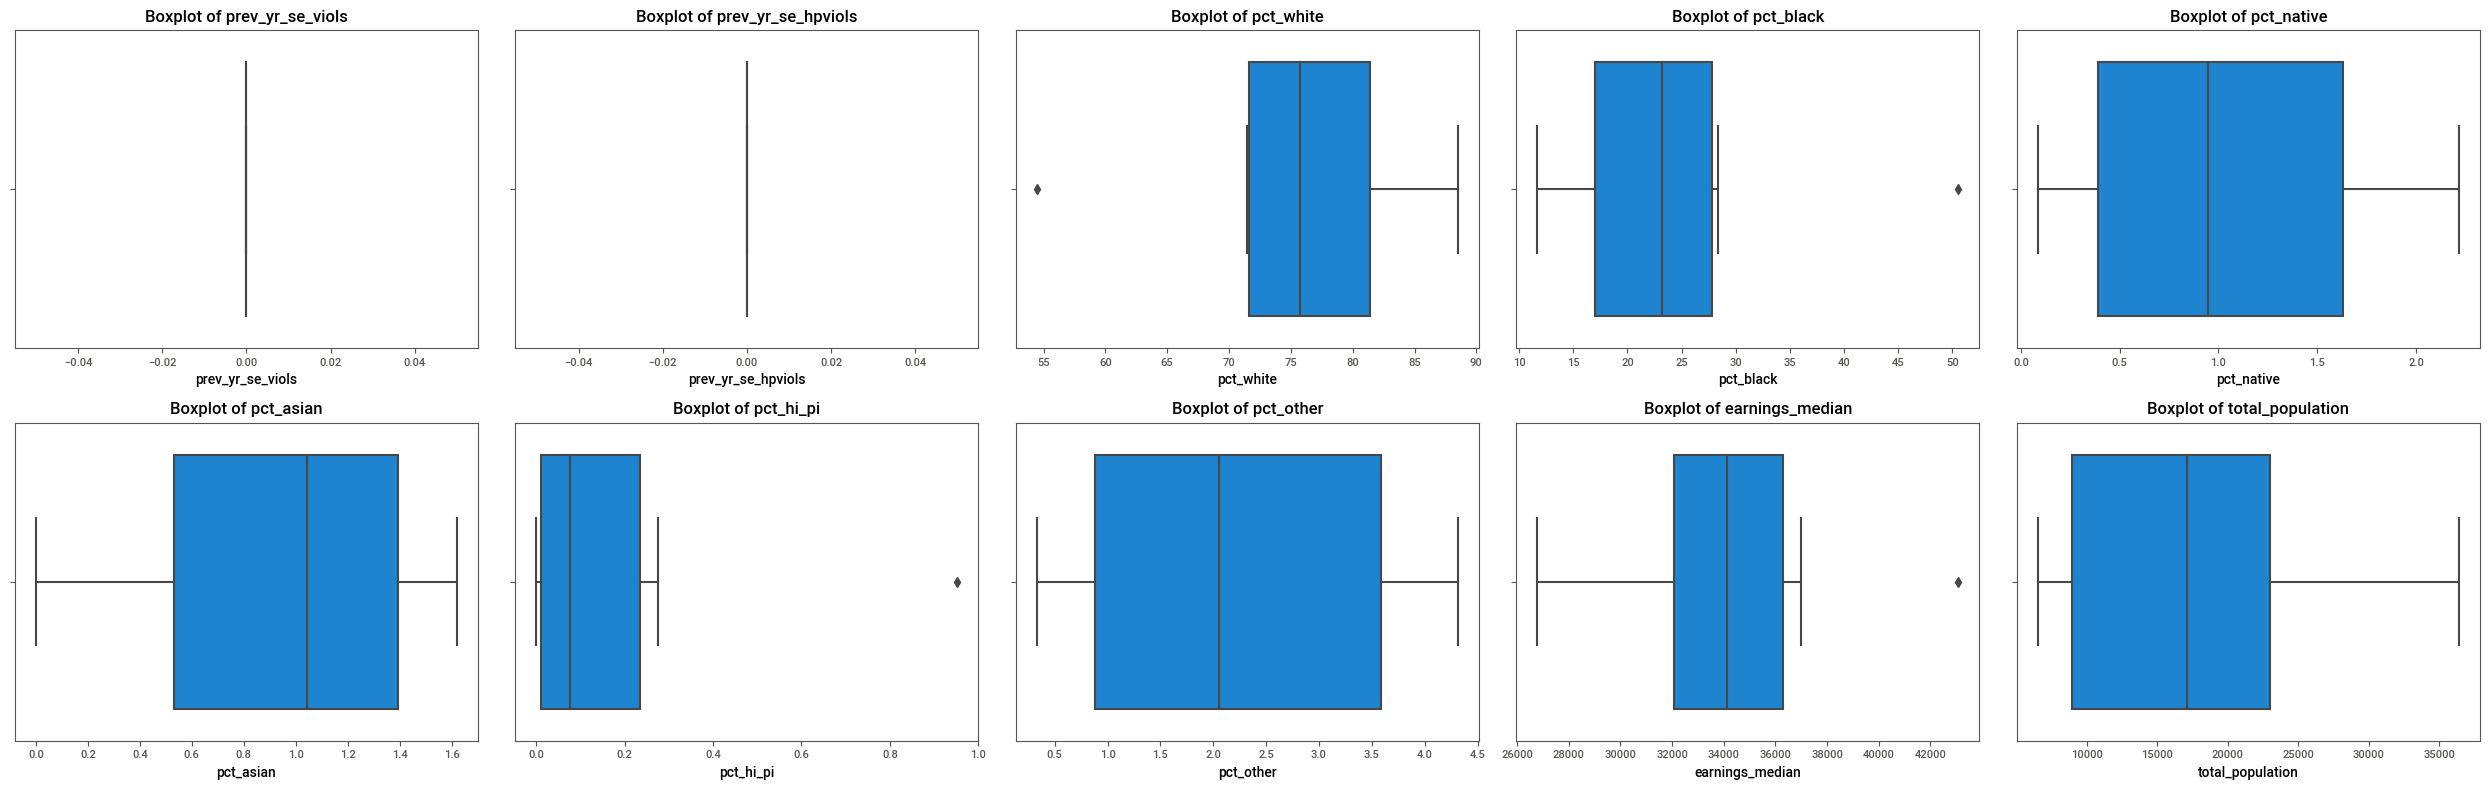

In [24]:
# AK
fig, axs = plt.subplots(2, columns_per_row, figsize=(5 * columns_per_row, 8)) 
for i, column in enumerate(AK.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(x=AK[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

if num_columns % 2 != 0:
    axs[1, -1].set_visible(False)

plt.tight_layout()
plt.show()

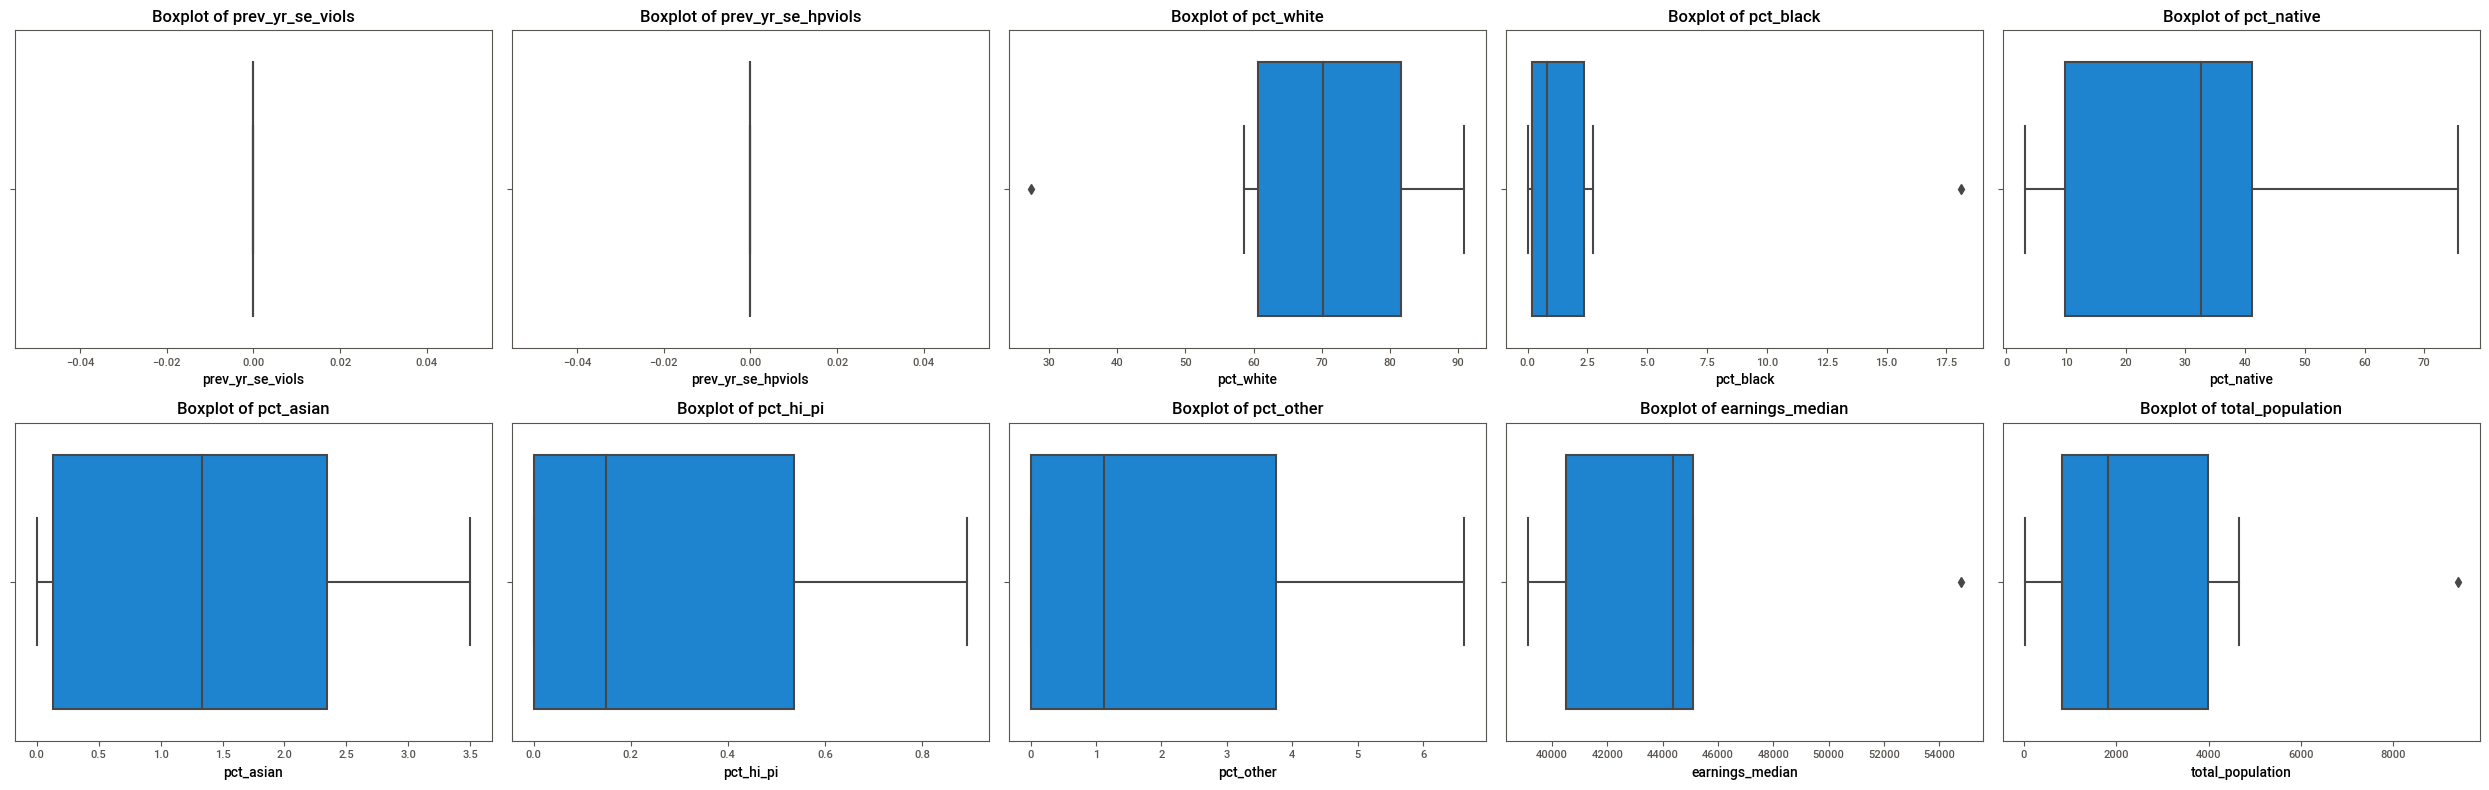

In [25]:
# WY
fig, axs = plt.subplots(2, columns_per_row, figsize=(5 * columns_per_row, 8)) 
for i, column in enumerate(WY.columns):
    row = i // columns_per_row
    col = i % columns_per_row
    sns.boxplot(x=WY[column], ax=axs[row, col])
    axs[row, col].set_title(f'Boxplot of {column}')

if num_columns % 2 != 0:
    axs[1, -1].set_visible(False)

plt.tight_layout()
plt.show()

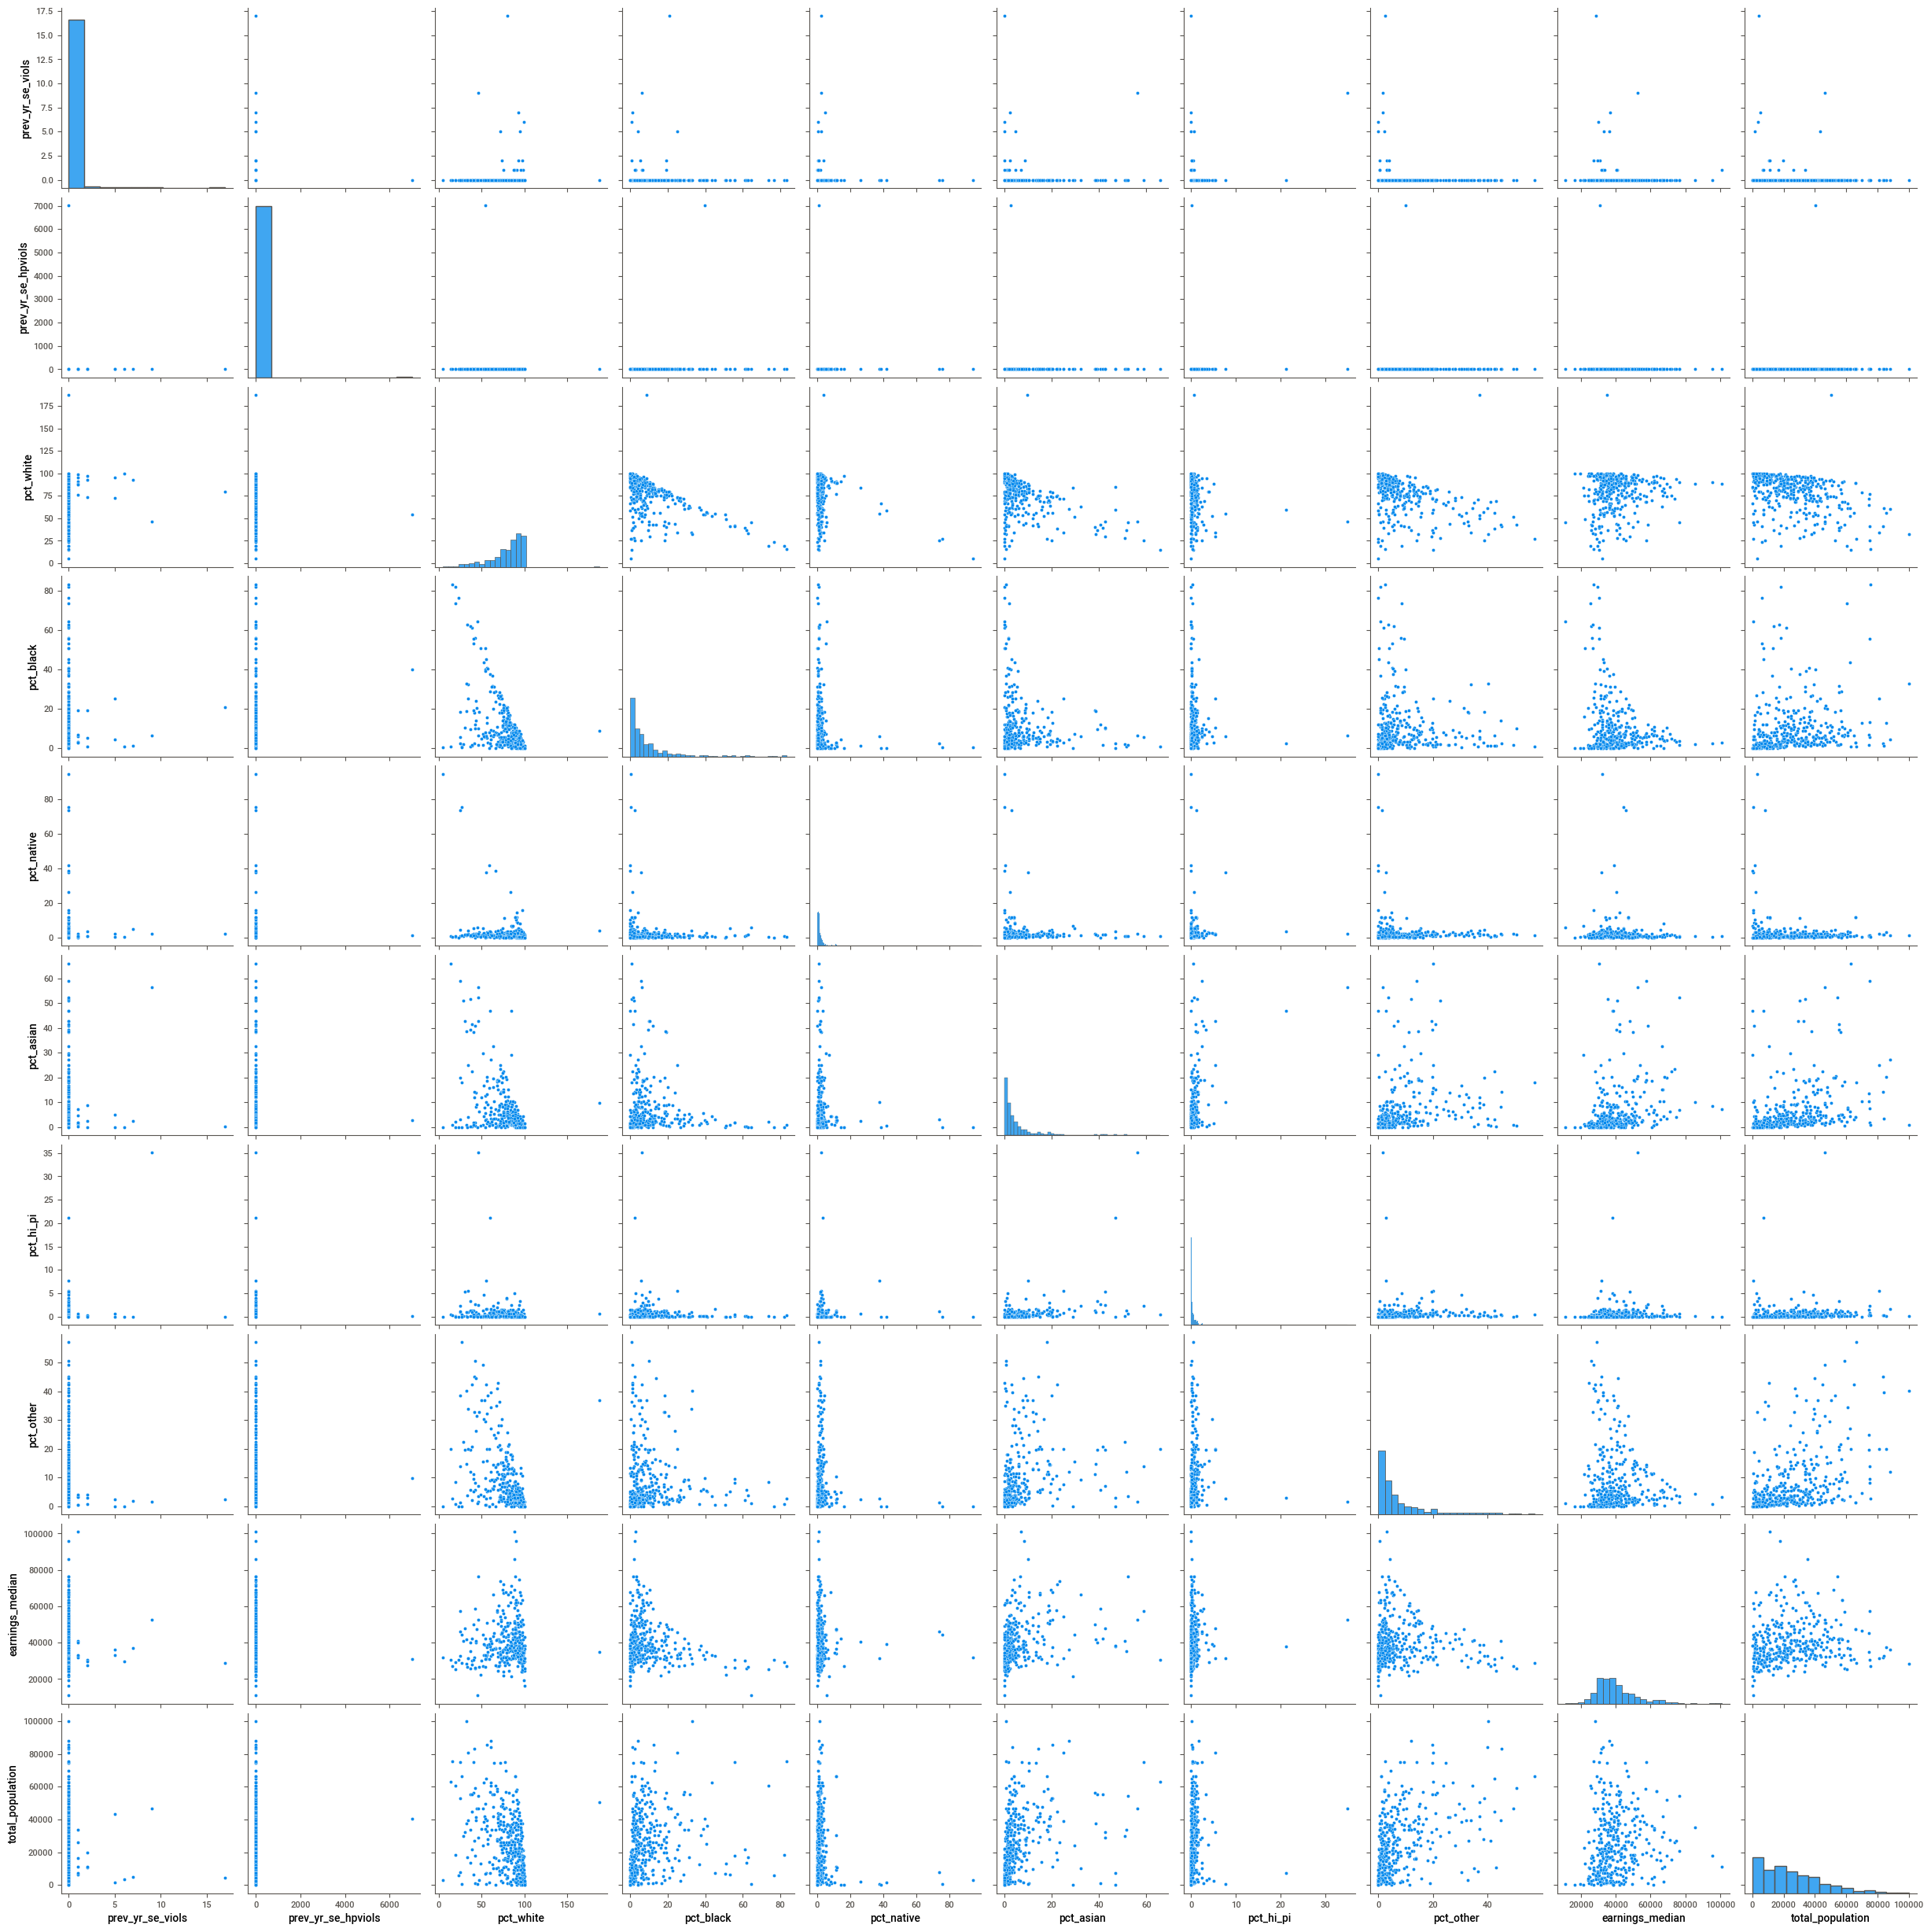

In [26]:
# Total pairplot
sns.pairplot(outlier_df)

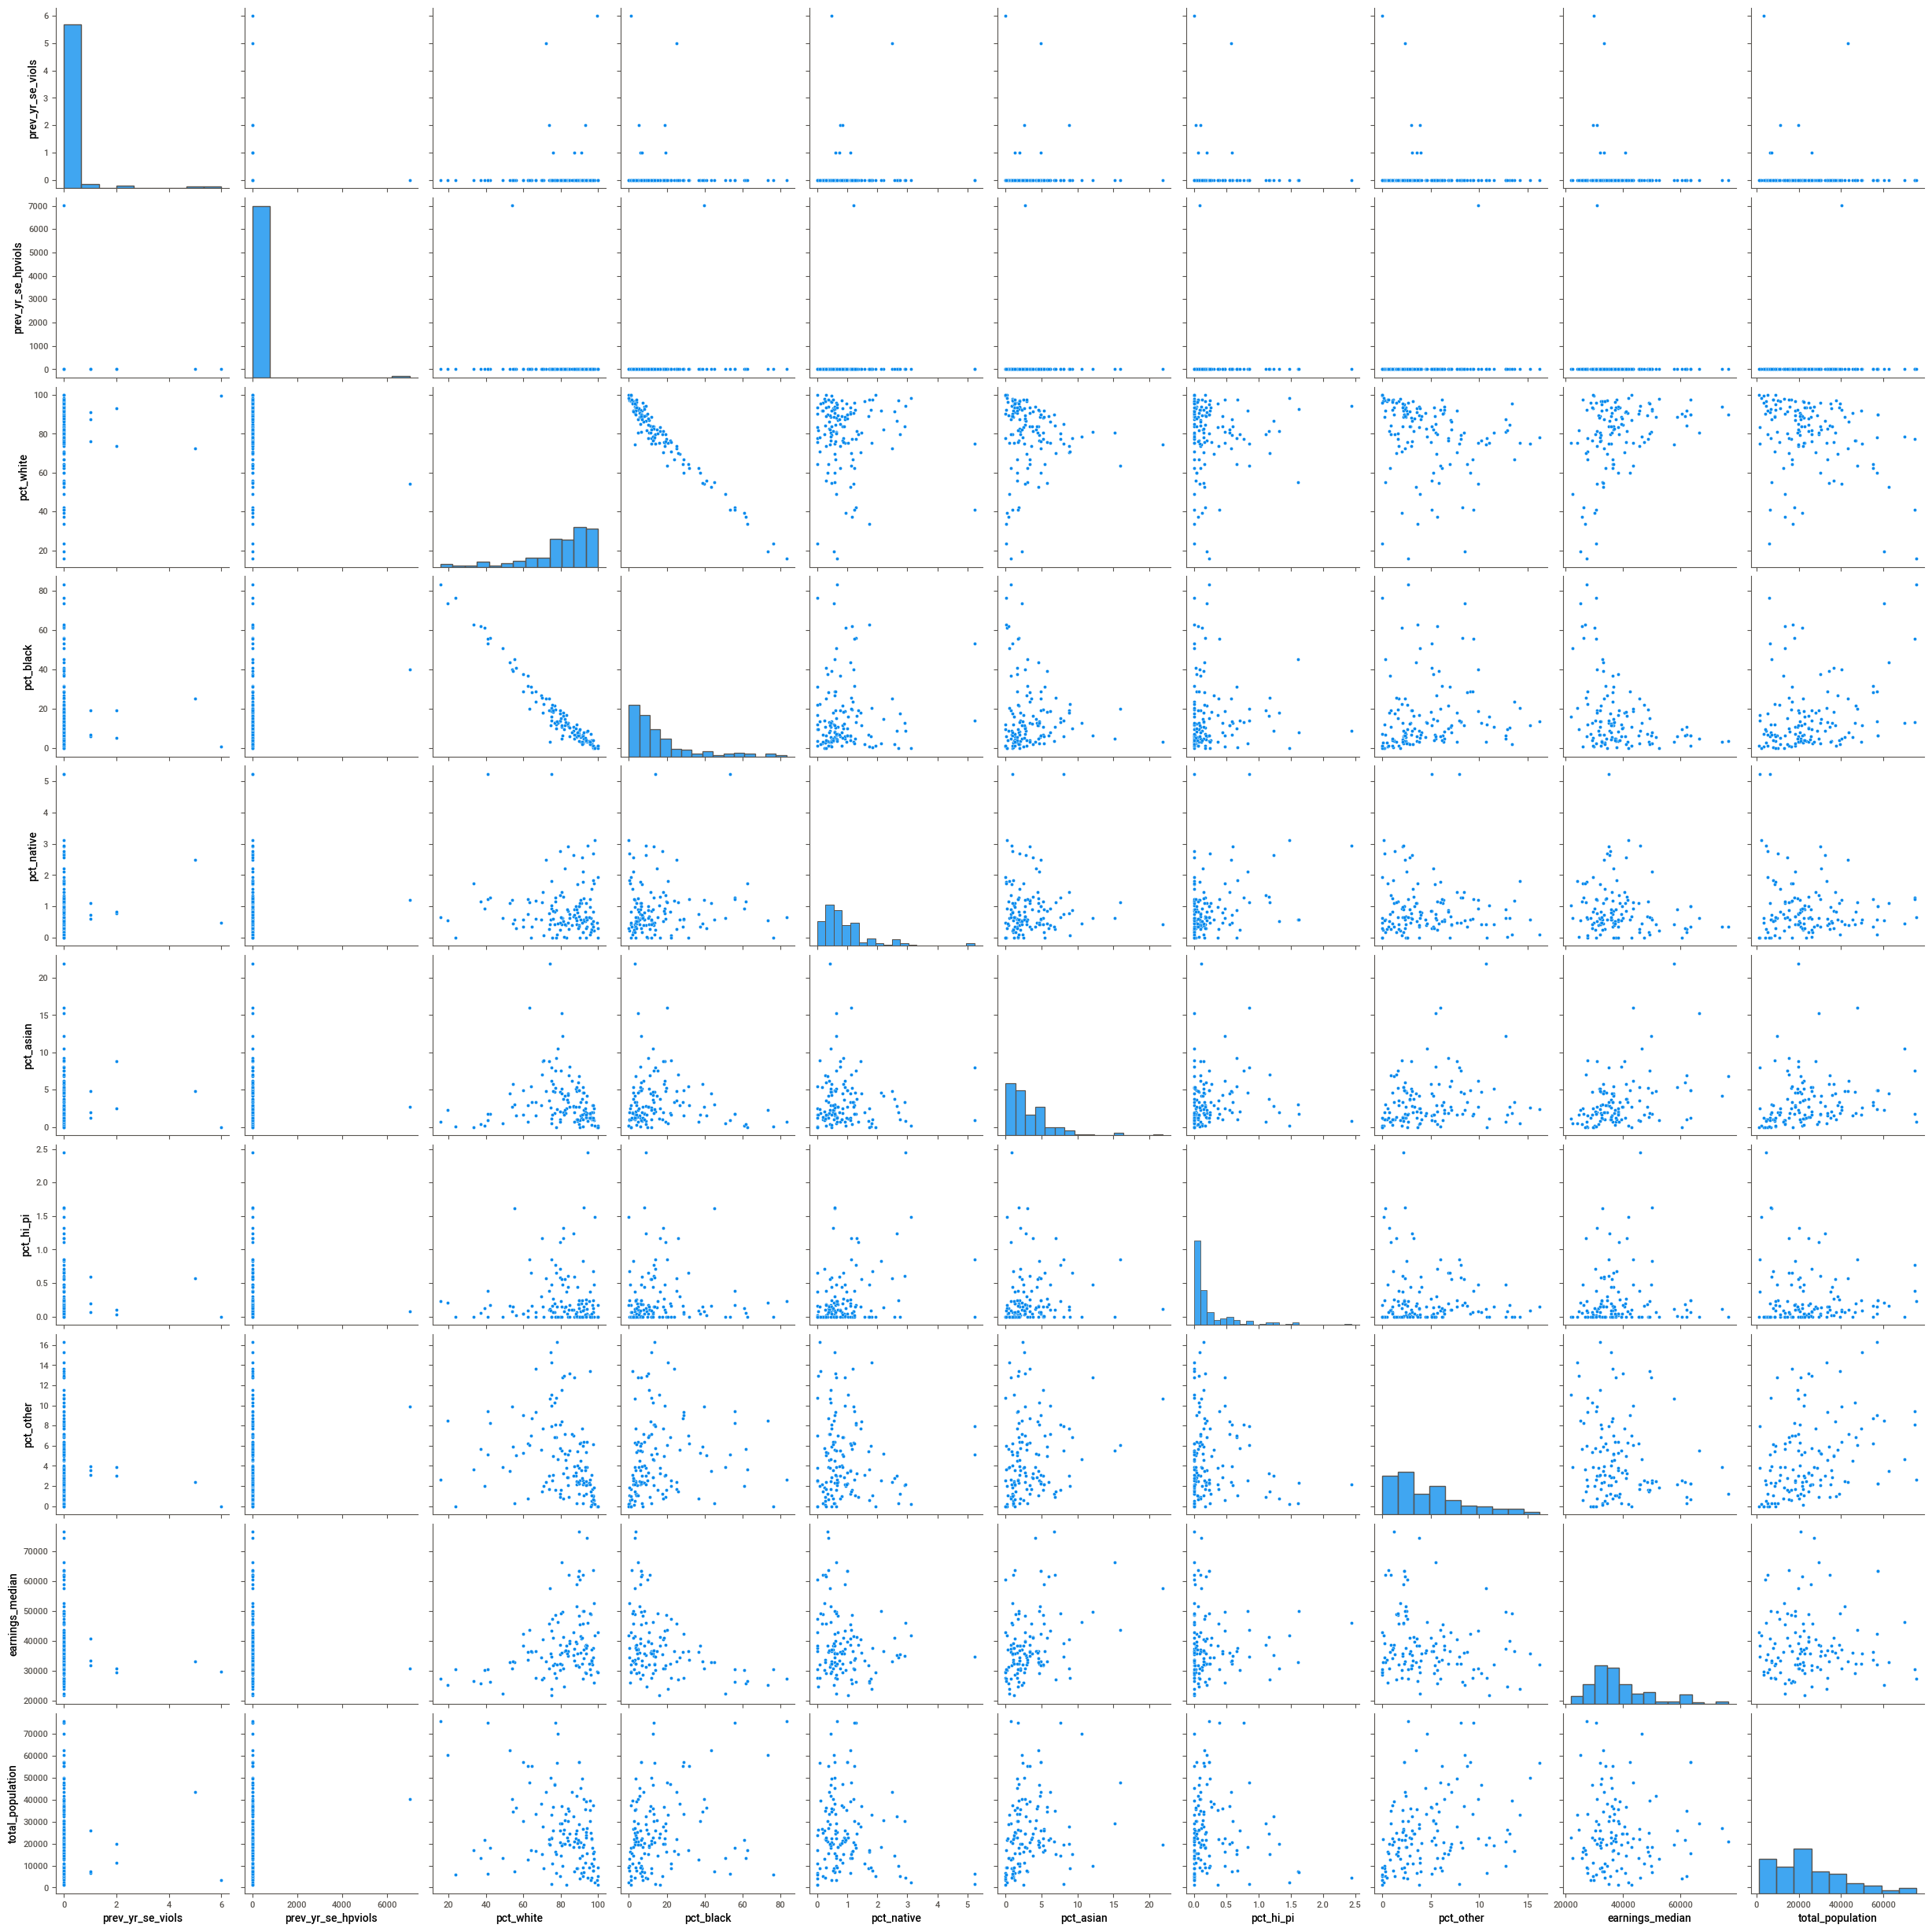

In [27]:
# CA pairplot
sns.pairplot(CA)

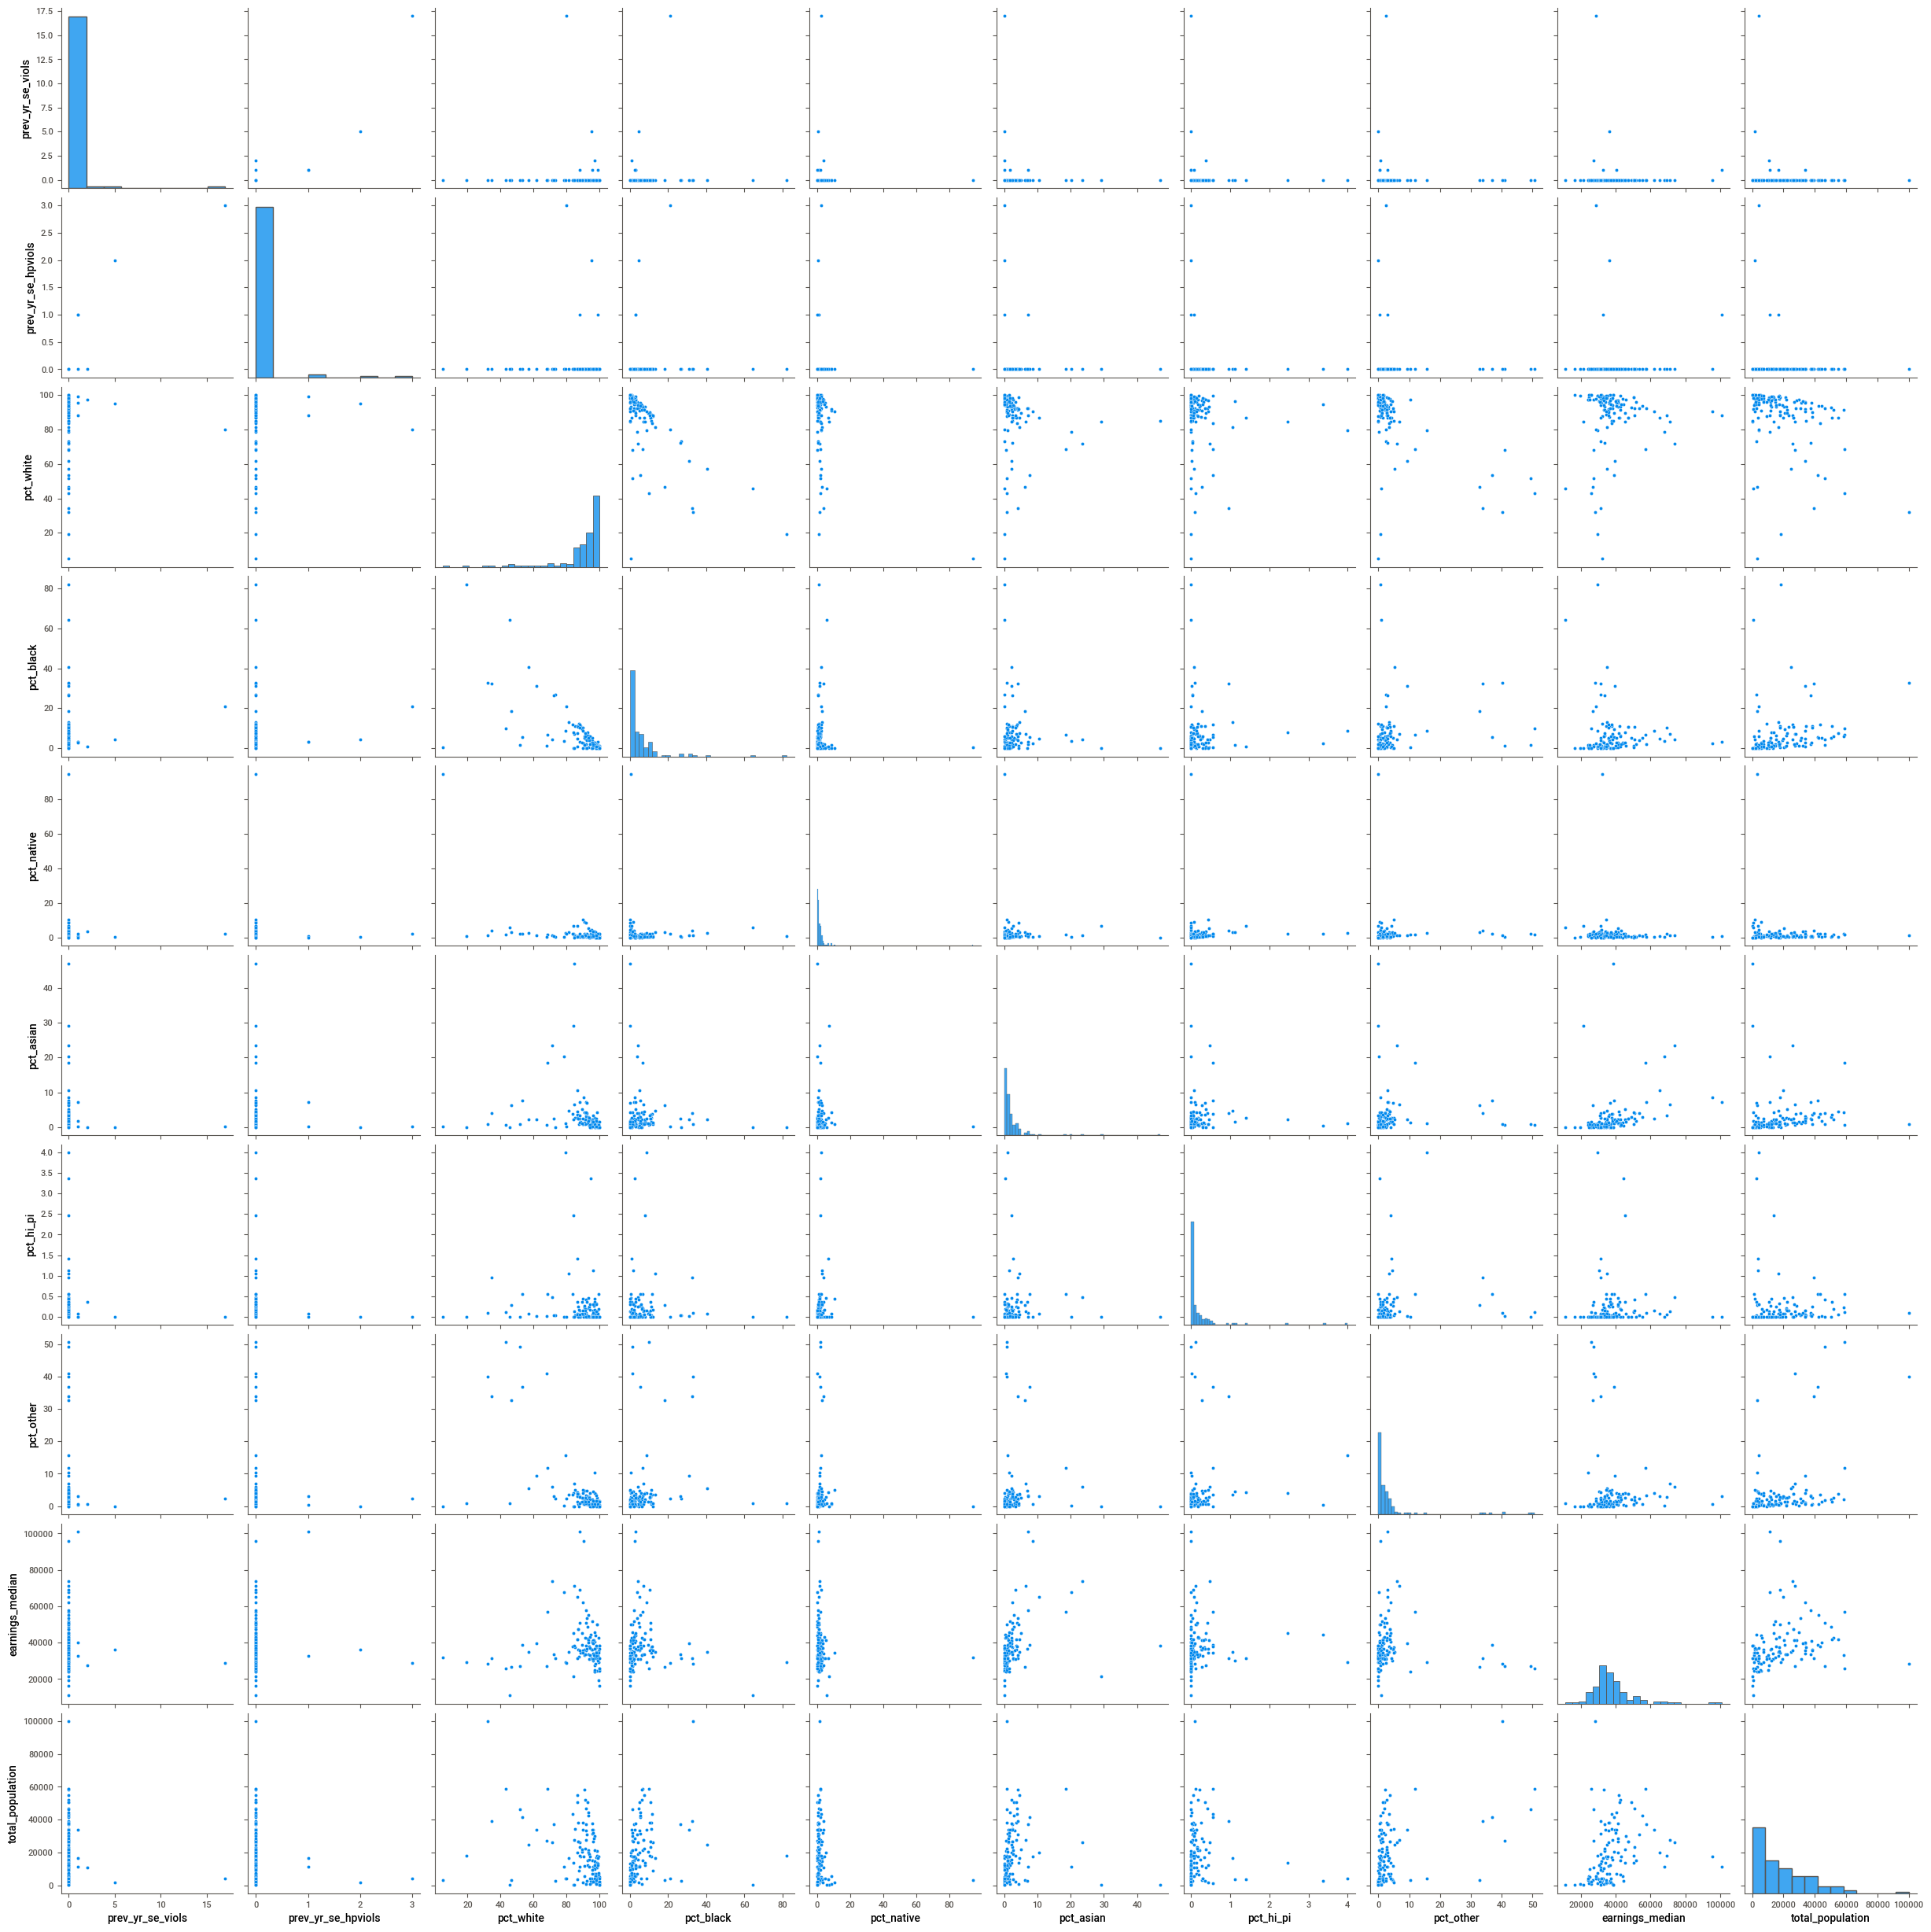

In [28]:
# FL pairplot
sns.pairplot(FL)

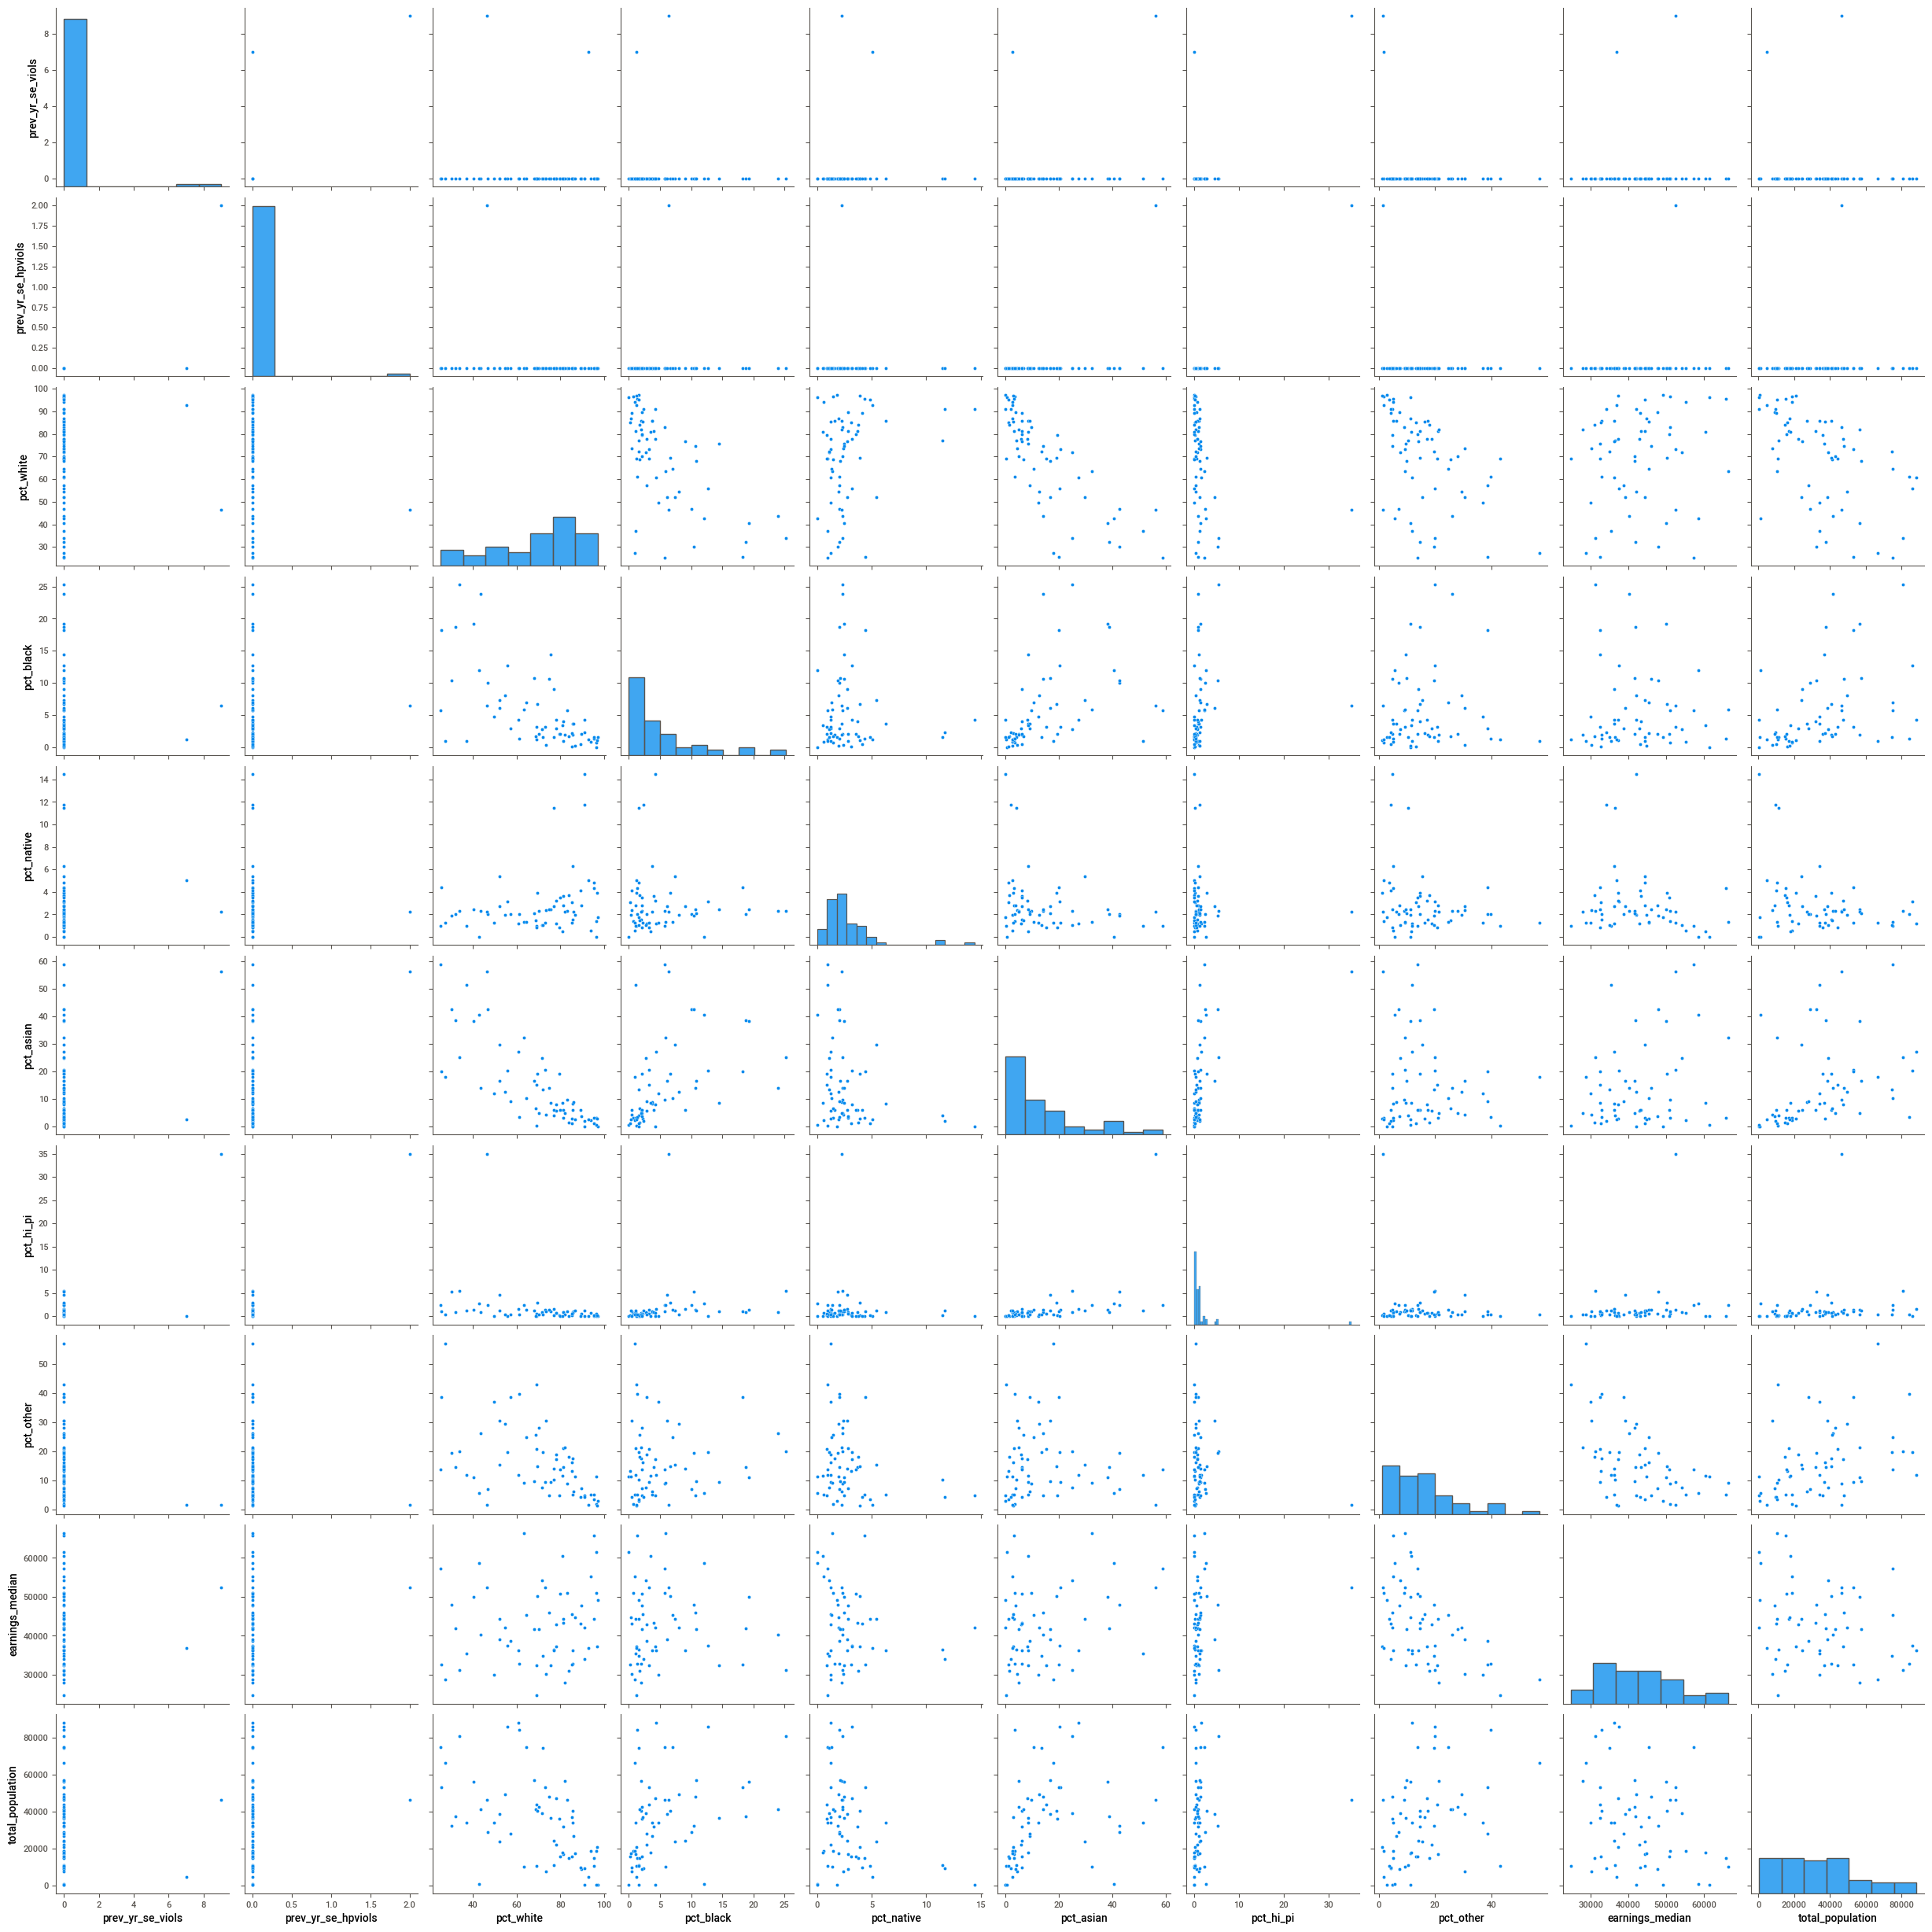

In [29]:
# MO pairplot
sns.pairplot(MO)

To handle outliers, there are two methods: considering the outliers per state or as a whole in the dataset.

In the first case, I would evaluate each independent distribution for each variable within each state to identify outliers. From the three pair plots of the states with the most facilities, it's evident that some outliers exist. However, it would be counterproductive to address outliers in states with fewer than approximately 60 facilities. In such states, the scarcity of facilities might mean we don't have enough data to accurately assess the real-world distribution; therefore, what we identify as outliers might, in fact, be integral parts of the distribution.

Furthermore, some variables, especially those concerning violations, are expected to have values significantly above the average, reflecting the reality of specific companies committing more violations than others. Taking this into account is crucial for their accurate identification. Given this, along with its economic significance, a viable solution would be to employ machine learning models capable of accommodating outliers and making predictions through them.

Another method to handle outliers is to consider them as part of a larger, unified distribution to create a general prediction model that controls for the single-state variable. In this approach, all observations together contribute to the distributions of a single variable, without segregating by state. However, this method might have some risks, as some data points might differ in magnitude due to state variations and differences and thus be deemed outliers in the overall distribution. Still, this issue may be irrelevant; mixing multiple magnitudes together creates a new distribution that allows for analyzing the dataset without state-based grouping. In this scenario, outliers are simply data points far removed from the mixed distributions.

I plan to filter out outliers using the Isolation Forest technique, setting a low contamination level to accommodate magnitude differences and unique observations. Additionally, I will not consider the number of violations in previous years, as facilities with a high number of violations are still relevant to our analysis.

Ultimately, I will personally explore both approaches: one that includes outliers and one that excludes them. I will display only the selected approach.

In [30]:
# Isolation Forest - Outliers determination
data_out_analysis = df.drop(['registry_id', 'state', 'region_code', 'violation', 
                             'prev_yr_se_viols', 'prev_yr_se_hpviols'], 
                            axis=1).dropna()
indices_out_analysis = data_out_analysis.index 
iso_forest = IsolationForest(contamination=0.01)  
outliers = iso_forest.fit_predict(data_out_analysis)
df['Outlier'] = np.nan
df.loc[indices_out_analysis, 'Outlier'] = outliers
outlier_df = df[df['Outlier'] == -1]

outlier_df.shape[0]

4

In [31]:
outlier_df.state.value_counts()

FL    1
MO    1
CA    1
MT    1
Name: state, dtype: int64

In [32]:
# Create a copy of the df 
df_copy = df.copy()

In [33]:
# Filter out outliers
df = df[df['Outlier'] != -1]
df = df.drop('Outlier', axis=1)

#### 2. Create a nicely-formatted table of summary statistics by state for the three states with the most facilities in the dataset. 

In [34]:
# CA summary statistics
df[df['state'] == 'CA'].drop(['registry_id', 'year', 'region_code'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
prev_yr_se_viols,134.0,0.134328,0.723307,0.000000,0.000000,0.000000,0.000000,6.000000
prev_yr_se_hpviols,134.0,52.395522,605.912858,0.000000,0.000000,0.000000,0.000000,7014.000000
pct_white,134.0,80.654051,16.558472,19.579818,75.135797,84.081381,92.252956,100.000000
pct_black,134.0,15.199343,16.089146,0.000000,4.166751,10.072118,19.242878,76.417910
pct_native,134.0,0.920718,0.864565,0.000000,0.429442,0.638262,1.157730,5.237515
pct_asian,134.0,3.368976,3.319008,0.000000,1.210954,2.452073,4.721686,21.934827
pct_hi_pi,134.0,0.258107,0.400324,0.000000,0.000000,0.105062,0.264576,2.442334
pct_other,134.0,4.677121,3.796664,0.000000,1.993771,3.614779,6.716431,16.278006
earnings_median,124.0,38811.887097,10811.504518,21725.000000,31962.500000,36425.500000,42853.000000,76612.000000
total_population,134.0,24752.656716,16370.508665,1117.000000,12979.000000,21661.000000,34214.500000,74913.000000


In [35]:
# FL summary statistics
df[df['state'] == 'FL'].drop(['registry_id', 'year', 'region_code'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
prev_yr_se_viols,132.0,0.204545,1.551845,0.000000,0.000000,0.000000,0.000000,17.000000
prev_yr_se_hpviols,132.0,0.053030,0.334171,0.000000,0.000000,0.000000,0.000000,3.000000
pct_white,132.0,89.329428,14.889537,19.367914,87.886965,94.130039,97.896770,100.000000
pct_black,132.0,6.113075,11.053375,0.000000,0.721627,2.530860,6.813128,82.017856
pct_native,132.0,1.570719,1.794353,0.000000,0.484560,0.961462,2.106585,10.416667
pct_asian,132.0,2.786242,5.696229,0.000000,0.501020,1.243095,2.600768,46.987952
pct_hi_pi,132.0,0.202233,0.532985,0.000000,0.000000,0.026034,0.176912,3.994155
pct_other,132.0,3.970926,9.155623,0.000000,0.368616,1.296492,3.105906,50.640960
earnings_median,124.0,38265.024194,13132.104430,10938.000000,31232.250000,35848.000000,41472.250000,100957.000000
total_population,132.0,18042.340909,17088.776146,166.000000,4091.250000,13604.000000,27234.250000,99980.000000


In [36]:
# MO summary statistics
df[df['state'] == 'MO'].drop(['registry_id', 'year', 'region_code'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
prev_yr_se_viols,63.0,0.111111,0.881917,0.000000,0.000000,0.000000,0.000000,7.000000
prev_yr_se_hpviols,63.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pct_white,63.0,70.022238,20.359343,25.226797,56.619837,74.661993,85.502055,97.127223
pct_black,63.0,5.307132,5.844793,0.000000,1.540241,2.890821,6.840415,25.266569
pct_native,63.0,2.780902,2.579433,0.000000,1.264459,2.243159,3.191584,14.447592
pct_asian,63.0,13.561451,13.805024,0.000000,3.361913,8.526875,19.202016,59.043255
pct_hi_pi,63.0,0.994575,1.170534,0.000000,0.236385,0.694581,1.238312,5.462507
pct_other,63.0,15.941699,11.617564,1.276309,7.245259,13.830259,20.376258,57.112964
earnings_median,59.0,42362.627119,9741.128838,24663.000000,35169.500000,41948.000000,48561.500000,66415.000000
total_population,63.0,34186.730159,23116.172591,353.000000,15840.500000,33943.000000,46780.000000,88173.000000


#### 3. Identify an interesting correlation in the data between the outcome of interest and a covariate and produce a nicely formatted graph illustrating that relationship. Give a brief explanation of what your figure displays and discuss possible interpretations. 


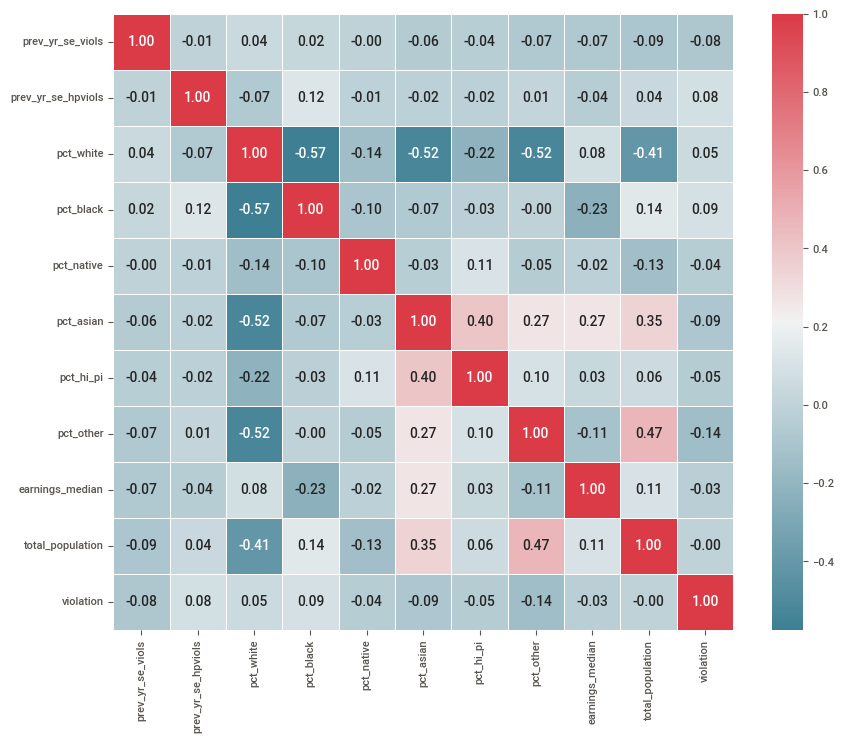

In [37]:
# Correlation Matrix

sub_df = df.drop(['registry_id', 'year', 'state', 'region_code'], axis=1)
corr = sub_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
dropvals = np.zeros_like(corr)
dropvals[np.triu_indices_from(dropvals)] = True
sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f")
plt.show()

Generally, there are not high correlations between variables. However, we can find medium and low correlated variables.

pct_black and pct_white: There is a moderate negative correlation of -0.57, indicating that a population with higher percentages of black individuals also tend to have lower percentages of whites.

pct_white and pct_asian: There is a moderate negative correlation of -0.52, indicating that a population with higher percentages of white individuals also tend to have lower percentages of asians. 

pct_white and pct_others: There is a low-moderate negative correlation of -0.52, indicating that a population with higher percentages of white individuals also tend to have lower percentages of other races.

total_population and pct_white: There is a low negative correlation of -0.41, indicating that the total population is negatively related to the number of white people.

total_population and pct_other: There is a low-moderate positive correlation of 0.47, indicating that the total population is positively related to the number of people identifying with other races.

pct_asian and pct_hi_pi: There is a low-moderate positive correlation of 0.40, indicating that a population with higher percentages of white individuals also tend to have higher percentages of people identifying as Hawaiian or Pacific Islander.

total_population and pct_asian: There is a low positive correlation of 0.35, indicating that the total population is positively related to the number of people identifying as asians.

In [38]:
df.to_csv("cleaned.csv")

## 3) Prediction

Now, use the data that you processed in the previous section (cleaned.csv) to make predictions about whether a facility with a given set of characteristics would be found in violation if it were inspected. We are primarily interested in seeing how you develop this model, and how you describe the reasoning behind it.  We are less interested in how well your model performs.


#### 1. The E&E Lab wants to use the data from the previous inspection cycles (your cleaned data) to make a prediction about how likely it is that each firm that they intend to inspect next year shows a violation. What is a statistical tool that you could use to generate these predictions? Discuss what approach you would try first given the nature of the problem and the structure of the data. 


Given the presence of several observations that might be considered difficult to handle, I aim to develop predictive models for classification purposes with high flexibility, capable of accommodating such data. I will construct three machine learning model pipelines, tuning their hyperparameters using the built-in function GridSearchCV().

Firstly, I will establish a benchmark logistic regression model. I will tune the hyperparameters to explore the possibility of adding either an L1 or L2 penalty. Given the complexity of the data and the presence of numerous variables, I intend to mitigate the impact of irrelevant estimators. In this case, data scaling will also be employed.

Subsequently, I will implement a Random Forest Classifier. This choice is motivated by its resilience to outliers and its ability to handle potential nonlinearities and complex data structures.

Lastly, I will employ XGBoost for classification. Similar to the Random Forest Classifier, XGBoost is well-suited for handling complex data and capturing nonlinear relationships.

This approach ensures a comprehensive exploration of various modeling techniques, enabling us to identify the most suitable algorithm for our classification task.

In [39]:
df = pd.read_csv('cleaned.csv')

In [40]:
df = df.drop('Unnamed: 0', axis=1)

#### 2. How do you plan to handle missing values in our outcome variable? How about control variables? Make these modifications to the dataset cleaned in section 2 (*cleaned.csv*) and briefly explain your reasoning in words.

In [41]:
# Visualize missing values
df_missing = df[df.isnull().any(axis=1)]
df_missing.shape[0]

44

In [42]:
df_missing.state.value_counts()

CA    17
FL    16
MO     5
KY     5
WY     1
Name: state, dtype: int64

In [43]:
df_missing[df_missing['state'] == 'KY']   

,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population,violation
36,110070087974,2021,KY,0,0,90713,68.188497,7.471779,2.028310,18.953593,1.978140,14.488443,57693.0,27905,NaN
45,110070095320,2021,KY,0,0,91103,41.934642,17.978910,1.386146,11.938741,0.294370,32.891158,NaN,26837,0.0
49,110070091322,2021,KY,0,0,90745,36.564868,9.638814,1.497292,39.249915,3.241132,19.752731,40196.0,55567,NaN
106,110070090401,2021,KY,0,0,92203,80.024722,1.835600,1.773795,4.567367,0.358467,25.784920,NaN,32360,0.0
157,110066142301,2021,KY,0,0,91773,73.850992,3.257870,2.124440,18.001365,1.433107,11.049461,NaN,33703,0.0


In [44]:
# Check missing earnings data
df_missing_earnings = df[df['earnings_median'].isnull()]
df_missing_earnings.head()

,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population,violation
7,110012266467,2021,MO,0,0,92807,79.474166,2.055079,0.854203,19.302771,0.274565,4.936628,NaN,36057,1.0
32,110030914367,2021,FL,0,0,63670,96.083189,3.119584,0.415945,0.667244,0.000000,0.329289,NaN,11540,0.0
42,110070095876,2021,MO,0,0,95829,46.643000,10.019301,2.016268,42.696629,2.447095,7.103467,NaN,29014,0.0
45,110070095320,2021,KY,0,0,91103,41.934642,17.978910,1.386146,11.938741,0.294370,32.891158,NaN,26837,0.0
51,110070202689,2021,FL,0,0,64503,93.049911,8.031214,1.536336,1.698911,0.000000,1.999675,NaN,12302,0.0


In [45]:
df_missing_earnings.state.value_counts()

CA    10
FL     8
MO     4
KY     3
WY     1
Name: state, dtype: int64

5% of the data for 'violation' are missing, and only 6% of the data for 'median_earnings' are missing.

Dropping these would reduce the dataset size by approximately 10%. The majority of the missing data come from states such as CA and FL, which together represent 50% of the observations; deleting those would help average out the magnitude of different data, making the variable distributions even more cohesive.

Moreover, given the differences by state and the presence of non-uniform data, it would be challenging and potentially misleading to fill in the missing data for the outcome variable 'violation', as it might distort the reality excessively. We might consider deleting the column for median income, as the missing values exceed 5%. However, this variable could serve as a useful control variable to account for.

Another idea would be to delete only the rows where 'violation' is missing and use the SimpleImputer() command in the ML pipelines. Given that the missing data only come from states with more facilities, it would make sense to fill in the data with the mean income variable, as there is sufficient data to estimate a 'likely median_earnings' average.

After careful consideration, it seems more efficient to delete missing values for the outcome and retain observations for earnings, to avoid reducing the dataset size even further.

In [46]:
# Drop null values
#df1 = df.dropna(subset=['violation'])
df1 = df.dropna()

In [47]:
print(df.violation.mean())
print(df1.violation.mean())

0.30666666666666664
0.3068181818181818


#### 3. Using the modified dataset from the previous subsection, divide your data into a training and testing set such that 80% of the data is in the training set and 20% is in the testing set. Train or estimate the predictive model you selected in this first part of this question on the training set.

In [48]:
# Create a df for the model
data = df1.drop(['registry_id', 'year', 'region_code'], axis=1)

In [49]:
# Split data
df_other, df_test = train_test_split(
  data, 
  train_size=0.8,
  random_state=425,
  stratify=data.violation
  )
df_test.shape

(71, 12)

In [50]:
# Separate X and y
num_features = ['prev_yr_se_viols', 'prev_yr_se_hpviols', 'pct_white',
                'pct_black', 'pct_native', 'pct_asian', 'pct_hi_pi', 
                'pct_other', 'earnings_median', 'total_population']
cat_features = ['state']
features = np.concatenate([num_features, cat_features])

X_other = df_other[features]
y_other = df_other.violation

X_test = df_test[features]
y_test = df_test.violation

In [51]:
# Prepare column transformers
categorical_tf = Pipeline(steps = [
    ("encoder", OneHotEncoder())
])

numeric_tf = Pipeline(steps = [
    ("num_impute", SimpleImputer(strategy='mean')),
])

col_tf = ColumnTransformer(transformers = [
    ('num', numeric_tf, num_features),
    ('cat', categorical_tf, cat_features)
])

**Logit**

In [53]:
# Set up the model
log = LogisticRegression(
    penalty='l1',
    solver='sag',
    )

In [54]:
# Pipeline
log_pipe = Pipeline(steps = [
    ('col_tf', col_tf),
    ('std_tf', StandardScaler()),
    ('model', log)
    ])
log_pipe

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer())]),
                                                  ['prev_yr_se_viols',
                                                   'prev_yr_se_hpviols',
                                                   'pct_white', 'pct_black',
                                                   'pct_native', 'pct_asian',
                                                   'pct_hi_pi', 'pct_other',
                                                   'earnings_median',
                                                   'total_population']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['state'])])),
                ('std_tf', StandardScaler()),
                ('model', LogisticRegression(penalty='l1', solver='sag'))])

In [55]:
# Gridsearch parameters
p_grid = ['l1', 'l2']
C_grid = np.logspace(start=0.0, stop=20.0, base=10, num=100)
solver_grid = ['saga', 'liblinear']

log_tuned_parameters = {
    'model__penalty': p_grid,
    'model__C': C_grid,
    'model__solver': solver_grid,
}
log_tuned_parameters

{'model__penalty': ['l1', 'l2'],
 'model__C': array([1.00000000e+00, 1.59228279e+00, 2.53536449e+00, 4.03701726e+00,
        6.42807312e+00, 1.02353102e+01, 1.62975083e+01, 2.59502421e+01,
        4.13201240e+01, 6.57933225e+01, 1.04761575e+02, 1.66810054e+02,
        2.65608778e+02, 4.22924287e+02, 6.73415066e+02, 1.07226722e+03,
        1.70735265e+03, 2.71858824e+03, 4.32876128e+03, 6.89261210e+03,
        1.09749877e+04, 1.74752840e+04, 2.78255940e+04, 4.43062146e+04,
        7.05480231e+04, 1.12332403e+05, 1.78864953e+05, 2.84803587e+05,
        4.53487851e+05, 7.22080902e+05, 1.14975700e+06, 1.83073828e+06,
        2.91505306e+06, 4.64158883e+06, 7.39072203e+06, 1.17681195e+07,
        1.87381742e+07, 2.98364724e+07, 4.75081016e+07, 7.56463328e+07,
        1.20450354e+08, 1.91791026e+08, 3.05385551e+08, 4.86260158e+08,
        7.74263683e+08, 1.23284674e+09, 1.96304065e+09, 3.12571585e+09,
        4.97702356e+09, 7.92482898e+09, 1.26185688e+10, 2.00923300e+10,
        3.19926714e

In [58]:
n_folds = 6
log_search=GridSearchCV(
    log_pipe, 
    log_tuned_parameters, 
    cv=n_folds,
    # scoring='roc_auc',
    scoring='accuracy',
    n_jobs=1,
    refit=True,
    error_score='raise'
    ) 

In [59]:
log_search.fit(X_other, y_other)

GridSearchCV(cv=6, error_score='raise',
             estimator=Pipeline(steps=[('col_tf',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer())]),
                                                                         ['prev_yr_se_viols',
                                                                          'prev_yr_se_hpviols',
                                                                          'pct_white',
                                                                          'pct_black',
                                                                          'pct_native',
                                                                          'pct_asian',
                                                                          'pct_hi_pi',
                                                                          'pct_other',
                                                                          'earnings_median',
                                                                          'total_population']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          O...
       1.45082878e+16, 2.31012970e+16, 3.67837977e+16, 5.85702082e+16,
       9.32603347e+16, 1.48496826e+17, 2.36448941e+17, 3.76493581e+17,
       5.99484250e+17, 9.54548457e+17, 1.51991108e+18, 2.42012826e+18,
       3.85352859e+18, 6.13590727e+18, 9.77009957e+18, 1.55567614e+19,
       2.47707636e+19, 3.94420606e+19, 6.28029144e+19, 1.00000000e+20]),
                         'model__penalty': ['l1', 'l2'],
                         'model__solver': ['saga', 'liblinear']},
             scoring='accuracy')

In [60]:
log_search.best_params_

{'model__C': 2.535364493970112,
 'model__penalty': 'l1',
 'model__solver': 'liblinear'}

**Random Forest Classifier**

In [66]:
# Set up the model 
rfc = RandomForestClassifier(
    n_estimators=100, 
    criterion='gini',
    max_features='sqrt',
    oob_score=True,
    random_state=425
    )

In [67]:
# Pipeline
rfc_pipe = Pipeline(steps = [
    ('col_tf', col_tf),
    ('model', rfc)
    ])
rfc_pipe

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer())]),
                                                  ['prev_yr_se_viols',
                                                   'prev_yr_se_hpviols',
                                                   'pct_white', 'pct_black',
                                                   'pct_native', 'pct_asian',
                                                   'pct_hi_pi', 'pct_other',
                                                   'earnings_median',
                                                   'total_population']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['state'])])),
                ('model',
                 RandomForestClassifier(oob_score=True, random_state=425))])

In [207]:
# Gridsearch parameters
B_grid = np.linspace(start=100, stop=400, num=40, dtype=int) 
m_grid = ['sqrt', 'log2', 1.0] 
rfc_tuned_parameters = {
    'model__n_estimators': B_grid,
    'model__max_features': m_grid
    }
rfc_tuned_parameters 

{'model__n_estimators': array([100, 107, 115, 123, 130, 138, 146, 153, 161, 169, 176, 184, 192,
        200, 207, 215, 223, 230, 238, 246, 253, 261, 269, 276, 284, 292,
        300, 307, 315, 323, 330, 338, 346, 353, 361, 369, 376, 384, 392,
        400]),
 'model__max_features': ['sqrt', 'log2', 1.0]}

In [208]:
# Set up gridsearch
n_folds = 6
rfc_search = GridSearchCV(
    rfc_pipe,
    rfc_tuned_parameters,
    cv=n_folds, 
    scoring='roc_auc',
    n_jobs=8, 
    refit=True
    )

In [209]:
rfc_search.fit(X_other, y_other)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('col_tf',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer())]),
                                                                         ['prev_yr_se_viols',
                                                                          'prev_yr_se_hpviols',
                                                                          'pct_white',
                                                                          'pct_black',
                                                                          'pct_native',
                                                                          'pct_asian',
                                                                          'pct_hi_pi',
                                                                          'pct_other',
                                                                          'earnings_median',
                                                                          'total_population']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['state'])])),
                                       ('model',
                                        RandomForestClassifier(oob_score=True,
                                                               random_state=425))]),
             n_jobs=8,
             param_grid={'model__max_features': ['sqrt', 'log2', 1.0],
                         'model__n_estimators': array([100, 107, 115, 123, 130, 138, 146, 153, 161, 169, 176, 184, 192,
       200, 207, 215, 223, 230, 238, 246, 253, 261, 269, 276, 284, 292,
       300, 307, 315, 323, 330, 338, 346, 353, 361, 369, 376, 384, 392,
       400])},
             scoring='roc_auc')

<Figure size 640x480 with 0 Axes>

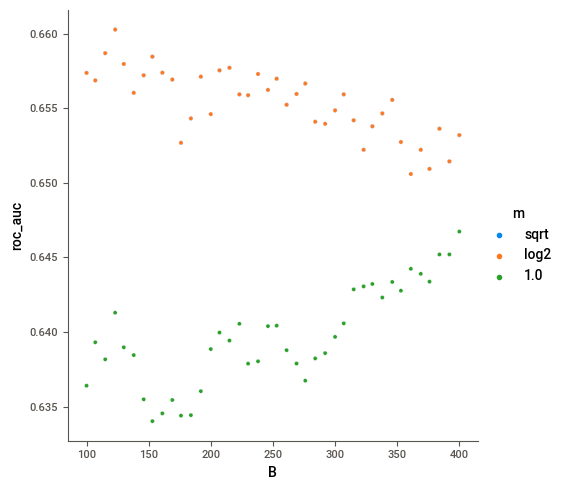

In [210]:
cv_res = pd.DataFrame({
    'B': np.array(rfc_search.cv_results_['param_model__n_estimators']),
    'roc_auc': rfc_search.cv_results_['mean_test_score'],
    'm': rfc_search.cv_results_['param_model__max_features']
    })

plt.figure()
sns.relplot(
    # kind = "line",
    data=cv_res,
    x='B',
    y='roc_auc',
    hue='m',
    ).set(
        xlabel='B',
        ylabel='roc_auc'
        );

plt.show()

In [211]:
rfc_search.best_params_

{'model__max_features': 'sqrt', 'model__n_estimators': 123}

**XGBoost Classifier**

In [184]:
# Set up the model
xgb = XGBClassifier(
    estimator=DecisionTreeClassifier(max_depth=2),
    verbosity=0,
    learning_rate=0.01,
    silent=True,
    warm_start=True,
    random_state=425
    )

In [185]:
# Pipeline
xgb_pipe = Pipeline(steps = [
    ('col_tf', col_tf),
    ('model', xgb)
    ])
xgb_pipe

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer())]),
                                                  ['prev_yr_se_viols',
                                                   'prev_yr_se_hpviols',
                                                   'pct_white', 'pct_black',
                                                   'pct_native', 'pct_asian',
                                                   'pct_hi_pi', 'pct_other',
                                                   'earnings_median',
                                                   'total_population']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['state'])])),
                ('model',
                 XGBClas...
                               eval_metric=None, feature_types=None, gamma=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [213]:
# Gridsearch parameters
d_grid = [
    RandomForestClassifier(max_depth = 1),
    DecisionTreeClassifier(max_depth = 1),
    RandomForestClassifier(max_depth = 2),
    DecisionTreeClassifier(max_depth = 2),
    RandomForestClassifier(max_depth = 3),
    DecisionTreeClassifier(max_depth = 3),
    RandomForestClassifier(max_depth = 4),
    DecisionTreeClassifier(max_depth = 4)
    ]
B_grid = np.linspace(start=1, stop=70, num=70, dtype=int)
lambda_grid = np.linspace(start=0, stop=0.5, num=10)

xgb_params = {
    'model__estimator': d_grid,
    'model__n_estimators': B_grid,
    'model__learning_rate': lambda_grid
    }

xgb_params

{'model__estimator': [RandomForestClassifier(max_depth=1),
  DecisionTreeClassifier(max_depth=1),
  RandomForestClassifier(max_depth=2),
  DecisionTreeClassifier(max_depth=2),
  RandomForestClassifier(max_depth=3),
  DecisionTreeClassifier(max_depth=3),
  RandomForestClassifier(max_depth=4),
  DecisionTreeClassifier(max_depth=4)],
 'model__n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        69, 70]),
 'model__learning_rate': array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
        0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ])}

In [214]:
# Set up gridsearch
xgb_search = GridSearchCV(
    xgb_pipe,
    xgb_params,
    cv=n_folds,
    scoring='roc_auc',
    n_jobs=8, 
    refit=True
    )

In [215]:
tic = time.time()
xgb_search.fit(X_other, y_other)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

Execution time: 92.60714101791382 seconds


<Figure size 640x480 with 0 Axes>

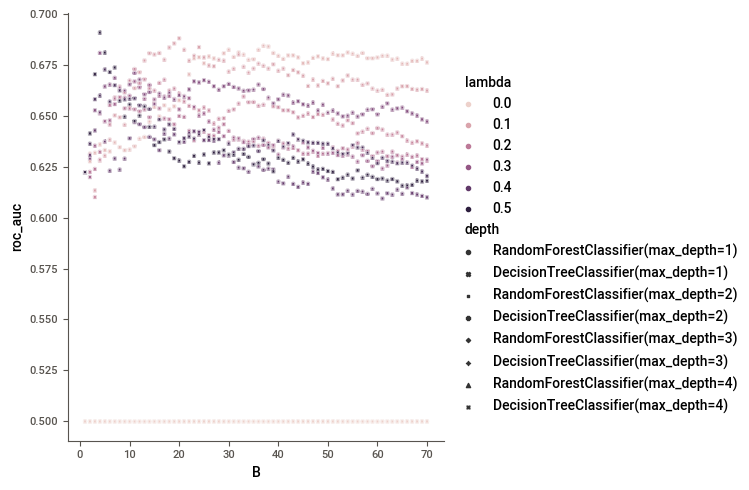

In [216]:
xgb_cv_res = pd.DataFrame({
    'B': np.array(xgb_search.cv_results_['param_model__n_estimators']),
    'roc_auc': xgb_search.cv_results_['mean_test_score'],
    'lambda': xgb_search.cv_results_['param_model__learning_rate'],
    'depth': xgb_search.cv_results_['param_model__estimator'],
    })

plt.figure()
sns.relplot(
    # kind = "line",
    data=xgb_cv_res,
    x='B',
    y='roc_auc',
    hue='lambda',
    style='depth'
    ).set(
        xlabel='B',
        ylabel='roc_auc'
        );

plt.show()

In [217]:
xgb_search.best_params_

{'model__estimator': RandomForestClassifier(max_depth=1),
 'model__learning_rate': 0.5,
 'model__n_estimators': 4}

#### 4. Evaluate the performance of your model on the testing data. Present nicely formatted figures or tables that illustrate how effective your model is at anticipating the likelihood of a violation.


In [192]:
log_pred = log_search.best_estimator_.predict(X_test)
log_acc = accuracy_score(
    y_test,
    log_pred
    )
print('Logit Accuracy:', round(log_acc*100, 2),'%')

Logit Accuracy: 80.28 %


In [193]:
rfc_pred = rfc_search.best_estimator_.predict(X_test)
rfc_acc = accuracy_score(
    y_test,
    rfc_pred
    )

print('Random Forest Accuracy:', round(rfc_acc*100, 2),'%')

Random Forest Accuracy: 76.06 %


In [219]:
xgb_pred = xgb_search.best_estimator_.predict(X_test)
xgb_acc = accuracy_score(
    y_test,
    xgb_pred
    )

print('XGBoost Accuracy:', round(xgb_acc*100, 2),'%')

XGBoost Accuracy: 74.65 %


The best model is the Logit model with 80% accuracy. To have the models return the best accuracy results, I dropped the missing observations rather than imputing. I will explore in the next section whether the logit model is the best one for prediction purposes.

#### 5. Using the trained/estimated model, generate predictions for the likelihood of violation for the facilities in *predict.csv*. Save these prediction scores as *predictions.csv* in the *output/* directory.


In [245]:
# Import predict
predict = pd.read_csv('predict.csv')
predict

,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population
0,110071147978,2022,AK,0,0,32073,41.174242,51.578733,0.698214,3.143321,0.395292,3.010198,30816.501438,42153
1,110071158671,2022,CA,0,0,34236,54.791559,40.985019,0.397499,2.281100,0.207783,1.337041,25272.000106,13384
2,110070227855,2022,FL,9,7,42642,79.370703,15.327096,0.060867,1.521678,0.000000,3.719656,32504.000000,12292
3,110071179989,2022,CA,0,0,40011,60.487078,38.949960,0.020850,0.437859,0.000000,0.104252,26034.329137,2973
4,110070667655,2022,FL,0,0,63967,61.809500,37.163399,1.027101,0.000000,0.000000,0.000000,23250.000000,1699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,110071236003,2022,FL,0,0,42455,55.421727,34.356825,0.166654,0.000000,2.036883,8.017911,33065.000000,3259
96,110070839642,2022,FL,0,0,42327,55.195895,44.209350,0.025859,0.090506,0.000000,0.478390,43696.000000,4394
97,110070073605,2022,CA,0,0,32922,42.062024,52.620950,0.412717,0.518092,0.197577,4.188640,30017.000000,17384
98,110071176979,2022,CA,0,0,32404,42.411144,51.936291,0.652919,2.593469,0.446118,1.960059,26093.571876,40300


In [246]:
# Check what states I have
predict.state.value_counts()

CA    49
FL    43
AK     6
WY     2
Name: state, dtype: int64

In [247]:
# Drop unrelevant variables
predict2 = predict.drop(['registry_id', 'year', 'region_code'], axis=1)

In [248]:
# Predict Random Forest
pred_rfc = rfc_search.predict(predict2)

In [249]:
predict['violation_prediction_rfc'] = pred_rfc

In [250]:
predict

,registry_id,year,state,prev_yr_se_viols,prev_yr_se_hpviols,region_code,pct_white,pct_black,pct_native,pct_asian,pct_hi_pi,pct_other,earnings_median,total_population,violation_prediction_rfc
0,110071147978,2022,AK,0,0,32073,41.174242,51.578733,0.698214,3.143321,0.395292,3.010198,30816.501438,42153,0.0
1,110071158671,2022,CA,0,0,34236,54.791559,40.985019,0.397499,2.281100,0.207783,1.337041,25272.000106,13384,0.0
2,110070227855,2022,FL,9,7,42642,79.370703,15.327096,0.060867,1.521678,0.000000,3.719656,32504.000000,12292,0.0
3,110071179989,2022,CA,0,0,40011,60.487078,38.949960,0.020850,0.437859,0.000000,0.104252,26034.329137,2973,0.0
4,110070667655,2022,FL,0,0,63967,61.809500,37.163399,1.027101,0.000000,0.000000,0.000000,23250.000000,1699,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,110071236003,2022,FL,0,0,42455,55.421727,34.356825,0.166654,0.000000,2.036883,8.017911,33065.000000,3259,0.0
96,110070839642,2022,FL,0,0,42327,55.195895,44.209350,0.025859,0.090506,0.000000,0.478390,43696.000000,4394,0.0
97,110070073605,2022,CA,0,0,32922,42.062024,52.620950,0.412717,0.518092,0.197577,4.188640,30017.000000,17384,1.0
98,110071176979,2022,CA,0,0,32404,42.411144,51.936291,0.652919,2.593469,0.446118,1.960059,26093.571876,40300,0.0


In [253]:
# Visualize violation data
violation = predict[predict['violation_prediction_rfc'] == 1]
violation.drop(['registry_id', 'year', 'region_code'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
prev_yr_se_viols,28.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
prev_yr_se_hpviols,28.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pct_white,28.0,53.162140,12.299446,16.874586,46.136020,54.255226,62.007959,71.702774
pct_black,28.0,40.233488,12.731283,19.252520,32.150765,41.311684,47.468860,78.179326
pct_native,28.0,0.588732,0.436555,0.088037,0.312291,0.472980,0.759410,2.178018
pct_asian,28.0,2.295424,1.849559,0.518092,1.291339,1.756685,2.322895,8.908166
pct_hi_pi,28.0,0.090327,0.091553,0.000000,0.019001,0.058955,0.136085,0.349044
pct_other,28.0,3.629889,2.702126,0.464729,1.808941,3.185920,4.389239,13.325350
earnings_median,28.0,38349.519706,10816.230801,22604.002582,30555.500000,38366.500000,42000.500000,67417.000000
total_population,28.0,28680.250000,11904.638264,7493.000000,21651.750000,25717.500000,37300.500000,53575.000000


In [254]:
# Visualize non-violation data
nonviolation = predict[predict['violation_prediction_rfc'] == 0]
nonviolation.drop(['registry_id', 'year', 'region_code'], axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
prev_yr_se_viols,72.0,0.194444,1.133844,0.000000,0.000000,0.000000,0.000000,9.000000
prev_yr_se_hpviols,72.0,0.138889,0.860814,0.000000,0.000000,0.000000,0.000000,7.000000
pct_white,72.0,61.208410,13.654220,17.404420,51.841442,60.339025,71.755796,89.579754
pct_black,72.0,33.200520,11.960140,6.010668,24.041491,34.522334,41.588829,58.803233
pct_native,72.0,1.049202,2.185273,0.000000,0.335021,0.629737,1.072052,17.866302
pct_asian,72.0,2.094856,4.616209,0.000000,0.261360,0.852367,2.245588,34.991830
pct_hi_pi,72.0,0.200534,0.323670,0.000000,0.000000,0.066734,0.312026,2.036883
pct_other,72.0,2.246478,3.291385,0.000000,0.461838,1.397986,2.624650,20.123946
earnings_median,72.0,34779.848849,8682.217457,18213.436547,28661.500000,33210.000000,39281.750000,61169.000000
total_population,72.0,18257.347222,15686.154666,770.000000,3489.250000,14068.000000,28161.500000,56217.000000


In [256]:
predict.violation_prediction_rfc.mean()

0.28

In [257]:
df1.violation.mean()

0.3068181818181818

In [258]:
# Predict Logit
pred_log = log_search.predict(predict2)

In [259]:
pred_log.mean()

0.08

Despite the logistic regression model exhibiting a higher accuracy of 80%, it predicts a lower percentage of companies committing violations compared to the actual 31% in the dataset. In contrast, the random forest classifier predicts a violation rate of 28%, which closely aligns with the original dataset's percentage. This suggests that the random forest model may offer a more accurate reflection of reality, especially given the complexity of the data. While logistic regression achieves higher accuracy, it may suffer from inconsistency and overfitting, resulting in a less reliable prediction.

I chose to invest more time in this analysis to train multiple models and prioritize accuracy over speed, considering its significance for the assessment's purpose. Training three different models provided a broader perspective on the achievable accuracy range with this type of data. Future endeavors could involve spending additional time fine-tuning parameters and exploring different data manipulation strategies, such as handling missing observations and outliers.

Through various trials, I observed that the models generally yield higher accuracy when missing observations are deleted and outliers are treated with less severity. This approach acknowledges the varying magnitudes of the variables across different states.

In [261]:
predict.to_csv('predictions.csv')

## 4) Data Analysis and Causal Inference 

Finally, you have an opportunity to demonstrate your understanding of econometrics and empirical research design for economic problems.     

#### 1. The partner now wants to find out whether employing a new type of air scrubber technology helps reduce emissions of a particular pollutant. They find that some of the facilities that they inspect already employ this technology and propose to the E&E Lab that we compare violation rates between firms with this technology and firms without it. Write a brief paragraph about how you would respond to the partner’s suggestion. 


I would express support for the idea as it presents an opportunity to assess the new technology's effectiveness in reducing pollution emissions. To ensure an efficient analysis, I would propose conducting a controlled study that accounts for confounding variables that might affect violation rates, such as firm size, industry type, geographic location, firm age, and history of violations. Additionally, I would suggest employing statistical methods to compare the rates, such as regression analysis employing endogenous variables, a difference-in-differences approach, or double machine learning to isolate and capture the impact of the air scrubber technology from other factors. This approach would provide a clearer picture of the technology's effectiveness and its impact on emissions.

#### 2. The partner now decides to run a field experiment with the E&E Lab. Given the cost of providing the new technology to the firms and the partner’s limited budget, at most 38 facilities can be in the treatment group. Think about how you would go about designing this experiment, with particular focus on the following questions: 

##### a) What information do you need before setting up the experiment? 

Baseline Emissions Data: Information on current emission levels of pollutants at each facility to understand the starting point and measure changes accurately.

Operational Details: Details on the size, type, and operational practices of the facilities, including existing pollution control measures, to identify any confounding factors.

Cost and Implementation Details: Information on the cost, maintenance, operational, and disposal requirements of the new technology to plan for its implementation.

Regulatory Context: Understanding of local environmental regulations and compliance requirements to ensure the study aligns with legal standards.

Budget Constraints: Detailed budget available for the experiment to manage the allocation of resources effectively.

##### b) How would you decide which facilities are in your treatment and control groups?

Randomization: Randomly assign facilities to the treatment and control groups to minimize bias and ensure comparability between groups.

Stratification: If there are significant differences in facility types or sizes, stratify the sample first (e.g., by industry type or size) and then randomly assign within each stratum to ensure the groups are balanced.

Matched Pairing: For smaller samples or when there are notable facility-specific characteristics, consider using matched pairs based on similar characteristics (e.g., size, type, baseline emissions) and randomly assigning one in each pair to the treatment.

Algorithms: For example, unsupervised learning techniques.

##### c) What outcome data would you like to collect on the facilities?

Emission Levels: Collect detailed data on the levels of specific pollutants before and after the implementation of the technology.

Compliance Rates: Monitor any changes in regulatory compliance rates or violations related to emissions.

Operational Impact: Assess any impacts on operational efficiency, costs, or production output to understand broader implications.

Maintenance and Operational Costs: Track the costs associated with the technology's operation and maintenance to evaluate its economic viability. Also, any data related to the durability would be useful.

Transitional Costs: Take into account the costs related to transitioning to the new technolgy.

##### d) What concerns do you have about the experimental set-up?

External Validity: The ability to generalize the findings beyond the study context, especially if the selected facilities are not representative of the broader industry.

Compliance and Implementation: Ensuring consistent and correct implementation of the technology across all treatment facilities.

Timeframe: Whether the duration of the experiment is sufficient to observe significant changes in emissions and compliance.

Confounding Variables: Potential unmeasured factors that could influence the outcomes, such as changes in production levels, shifts in regulatory policies, or other environmental initiatives undertaken by the facilities.

Attrition: Risk of facilities dropping out of the experiment or failing to comply with study requirements, which could bias the results.

#### 3. The Lab conducts the experiment, with facilities randomized to ensure that randomization is balanced across three characteristics: the county a facility is in, the facility’s age, and whether the facility has had previous regulatory action taken against it for pollution violations. After the experiment concludes, your colleague at the Lab produces the following regression table. You have been asked to present this table to the partner during an upcoming meeting. What do you see in the table? How do you explain the results to the partner (keeping in mind that the partner may not have as strong of a grasp of econometrics as you do)?


In [ ]:
# run cell to display image
Image(filename="./images/reg_1.png", width=300)

# If the image doesn't load due to path issues, kindly refer to the image named "reg_1.png" in 
# the "images/" directory.

There are two models presented with the purpose of finding the average treatment effect (ATE) of the new technology on the emissions of pollutants in pounds. The ATE measures the difference average outcomes between units assigned to the treatment (implementation of the technolgy) and units assigned to the control. The number of observations is 76 (at most, 38 facilities have been assigned a treatment).

The first model assumes that observations are independent and identically distributed (IID), while the second takes into account the clustering by county. In simpler words, the first model treats each facility's data as if it has no relation to the others (like flipping a coin), while the second model recognizes that facilities in the same area might be similar, like how students in the same classroom often perform similarly on tests. This is a more robust approach if emissions at facilities are correlated within counties. Additionally, the second model specification includes some control variables represented by X (county, facility's age, and record of previous violations). These help adjust for factors that might affect emissions other than the treatment, such as the age of the facility and past regulatory actions. The control mean is the average amount of pollutants emitted by the control group facilities, which is 101.7 pounds.

The first model suggests that the treatment caused a decrease of 4.398 pounds in pollutant emissions. However, the result is not statistically significant at any p-value level, suggesting that we do not have enough observations to state that the implementation of the air scrubber actually had any effect. The second model, on the other hand, suggests that the implementation of the technology caused a decrease in pollutant emissions of 5.957 pounds. This is statistically significant at the 0.1 level. This means that there is only a 10% chance that the observed reduction in emissions could have happened by random chance, and we are 90% confident that the new technology truly had an effect.

In general, this means that, on average, facilities using the new technology emitted around 6 pounds less of pollutant X per day than facilities not using it. While the first analysis was inconclusive, after taking into account the clustering of facilities by county, the results became significant, suggesting that the technology is effective at reducing emissions.

#### 4. Another round of funding allows us to run a second wave of the experiment with an expanded sample size. With wave 2 of the experiment completed, your colleague creates an updated version of her previous regression table using the new data. The new table is displayed below. How do you explain the updated results to the partner? What conclusions can you draw from our experiment? Please write a detailed answer to these questions and give a recommendation to your partner about how to use the broader results of this experiment.

In [ ]:
# run cell to display image
Image(filename="./images/reg_2.png", width=300)

# If the image doesn't load due to path issues, kindly refer to the image named "reg_2.png" in 
# the "images/" directory.

The second experiment allowed to increase the number of observations to 250, but we do not have any data about the number of facilities in the control group or treatment group - we may assume that the treatment group has still at most 38 facilities. However, in this case, the mean of the pounds of pollutant for the control group sliglty dropped to 99.43. 

Increasing the number of observations, the result of the first model became statistically significan at the 0.1 level. As a matter of fact, we have now more data to have a better overview of the situation. The result suggests that, on average, during the experiment, the facilties who had the new technology implemented experienced a drop of pounds of emission of -3.62 if compared to the contorl group. The result is even more clear for the second model, which experience an average reduction of -4.7. This time, the treatment effect is significant at the 0.05 level. In other words, we are 95% confident that the new air scrabber made the difference.

With this experiment completed, I would be inclined to adopt the technology. In fact, the experiment shows that there is a positive effect from adopting the air scrubber, as it emits fewer pounds of pollution. However, I would suggest conducting a cost-benefit analysis to estimate any hidden costs associated with adopting this technology, as well as gathering further information on its durability, maintenance costs, and disposal costs and externalities, to ensure the technology is truly more environmentally efficient in terms of pollution reduction. This analysis should include any long-term savings from potentially avoiding regulatory fines and health benefits. It would also be wise to assess the facilities’ capacities to integrate the new technology without disrupting current operations, as the transition may increase costs and externalities. If successfully implemented, the positive results from the experiment could inform policy recommendations for wider industry adoption.